In [1]:
import os
import glob
import shutil
import math

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns


In [2]:
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import label_figure

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [3]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def label_figure(fig, data_identifier):                                                                                                                                     
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)    

In [4]:
%matplotlib notebook

# Set source dirs

In [5]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

In [6]:
outdir = os.path.join(aggregate_dir, 'luminance-analysis')
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [7]:
if not os.path.exists(os.path.join(outdir, 'roi-luminance-arrays')):
    os.makedirs(os.path.join(outdir, 'roi-luminance-arrays'))

# Get aggregate data

In [8]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)


/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

# Select datasets with RFs + blobs

In [9]:
include_sessions = []
included_ixs = []
for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
    if any(['rf' in v for v in g['experiment'].values]) and 'blobs' in g['experiment'].values:
        include_sessions.append((animalid, session, fov))
        included_ixs.extend(g.index.tolist())
        
dsets = sdata.loc[included_ixs]
fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
dsets['fovnum'] = fovnums

print(dsets.shape)

(137, 6)


# Get counts per area

In [10]:
dsets[dsets['experiment']=='blobs'].groupby(['visual_area']).count()

animalid  experiment  fov  session  fovnum
visual_area                                            
Li                 13          13   13       13      13
Lm                 12          12   12       12      12
V1                 11          11   11       11      11

In [11]:
dsets[dsets['experiment'].isin(['rfs', 'rfs10'])].groupby(['visual_area']).count()

animalid  experiment  fov  session  fovnum
visual_area                                            
Li                 14          14   14       14      14
Lm                 12          12   12       12      12
V1                 15          15   15       15      15

In [12]:
# incl_sessions = ['20190522', '20191006', '20190616',
#                  '20190609', '20190614', '20191018']

# dsets = dsets[dsets['session'].isin(incl_sessions)]


In [13]:
#dsets.groupby(['visual_area']).count()


# Load data

In [14]:
def get_trial_stats(animalid, session, fovnum, curr_exp='blobs',
                                   traceid='traces001', response_type='dff',
                                   responsive_test='ROC', responsive_thr=0.05, n_stds=0.):
    print(animalid, session, curr_exp)
    # Load experiment neural data
    fov = 'FOV%i_zoom2p0x' % fovnum
    if curr_exp == 'blobs':
        exp = util.Objects(animalid, session, fov, traceid=traceid)
    elif curr_exp == 'gratings':
        exp = util.Gratings(animalid, session, fov, traceid=traceid)
    else:
        print("DUNNO WHAT TO LOAD.")
        
    exp.load(trace_type='dff', update_self=True, make_equal=True)
    labels = exp.data.labels.copy()

    # Get stimulus config info
    sdf = exp.data.sdf
    sdf = reformat_morph_values(sdf)
    n_conditions = len(sdf['size'].unique())
    color_list = sns.color_palette('cubehelix', n_conditions)
    cond_colors = dict((k, color_list[i]) for i, k in enumerate(sorted(sdf['size'].unique()))) #.keys()))

    # ----- PUPIL/FACE STUFF -------------------------------
    # Add stimulus config info to face data
    trial_key = pd.DataFrame({'config': [g['config'].unique()[0] \
                             for trial, g in labels.groupby(['trial'])],
                  'trial': [int(trial[5:]) \
                             for trial, g in labels.groupby(['trial'])]})
    trial_key.index = trial_key['trial']

    # ----- NEURAL STUFF -------------------------------

    # Get responsive cells
    responsive_cells, ncells_total = exp.get_responsive_cells(response_type=response_type,\
                                                              responsive_test=responsive_test, 
                                                              responsive_thr=responsive_thr,
                                                              n_stds=n_stds)
    
    # Get nrois x ntrials array
    s_on = labels['stim_on'].unique()[0]
    n_on = labels['nframes_on'].unique()[0]
    roi_responses = pd.DataFrame(np.vstack([np.nanmean(exp.data.traces.iloc[g.index[s_on:s_on+n_on]], axis=0)\
                                        for trial, g in labels.groupby(['trial'])]),
                                index=[int(trial[5:]) for trial, g in labels.groupby(['trial'])])

    print("%i out of %i cells pass responsive test." % (len(responsive_cells), ncells_total))
    neuraldata = roi_responses[responsive_cells]

    return neuraldata, trial_key, sdf
    

In [15]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [16]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import matplotlib.cm as cm

def create_color_bar(fig, hue_colors, hue_values, hue_param='label', #cmap='cube_helix', 
                     orientation='horizontal', cbar_axes=[0.58, 0.17, 0.3, 0.02]):

    cmap = ListedColormap(hue_colors)
    bounds = np.arange(0, len(hue_values))
    norm = BoundaryNorm(bounds, cmap.N)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array(bounds)

    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(mappable, cax=cbar_ax, boundaries=np.arange(-0.5,len(hue_values),1), \
                        ticks=bounds, norm=norm, orientation='horizontal')
    cbar.ax.tick_params(axis='both', which='both',length=0)
    cbar.ax.set_xticklabels(hue_values, fontsize=6) #(['%i' % i for i in morphlevels])  # horizontal colorbar
    cbar.ax.set_xlabel(hue_param, fontsize=12)

    return cbar

# Stim reformatiting functions

In [17]:
import cv2
from pipeline.python.classifications import rf_utils as rfutils

#  Load stimulus images

In [186]:
# Get image paths:
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'
#sdf = DATA[datakey]['sdf']
#morph_levels = [m for m in sdf['morphlevel'].unique() if m != -1]
object_list = ['D1', 'M14', 'M27', 'M40', 'M53', 'M66', 'M79', 'M92', 'D2']
#object_list = ['D1', 'D2']

image_paths = []
for obj in object_list:
    stimulus_type = 'Blob_%s_Rot_y_fine' % obj
    image_paths.extend(glob.glob(os.path.join(stimulus_dir, stimulus_type, '*_y0.png')))
print("%i images found for %i objects" % (len(image_paths), len(object_list)))

images = {}
for object_name, impath in zip(object_list, image_paths):
    im = cv2.imread(impath)
    if object_name == 'D1':
        object_name = 'M0'
    if object_name == 'D2':
        object_name = 'M106'
    images[object_name] = im[:, :, 0]
print("im shape:", images['M0'].shape)
image_list = sorted(images.keys(), key=natural_keys)


9 images found for 9 objects
('im shape:', (618, 1080))


In [192]:
import itertools
image_ratios = []
i=0
mpairs = list(itertools.combinations(image_list, 2))
for (m1, m2) in mpairs:
    imA = images[m1].mean()
    imB = images[m2].mean()
    lratio = imA/imB if imA < imB else imB/imA
    image_ratios.append(pd.DataFrame({'m1': m1, 'm2': m2, 'ratio': lratio}, index=[i]))
    i+=1
image_ratios = pd.concat(image_ratios, axis=0)

In [194]:
image_ratios.sort_values(by='ratio')

m1    m2     ratio
7    M0  M106  0.719249
6    M0   M92  0.727380
5    M0   M79  0.738734
14  M14  M106  0.762184
4    M0   M66  0.762914
13  M14   M92  0.770800
12  M14   M79  0.782832
3    M0   M53  0.791652
11  M14   M66  0.808455
20  M27  M106  0.812156
19  M27   M92  0.821336
2    M0   M40  0.829076
18  M27   M79  0.834157
10  M14   M53  0.838908
17  M27   M66  0.861460
25  M40  M106  0.867532
24  M40   M92  0.877338
9   M14   M40  0.878566
1    M0   M27  0.885605
23  M40   M79  0.891033
16  M27   M53  0.893910
29  M53  M106  0.908542
28  M53   M92  0.918813
22  M40   M66  0.920198
27  M53   M79  0.933155
15  M27   M40  0.936168
8   M14   M27  0.938470
32  M66  M106  0.942766
0    M0   M14  0.943669
31  M66   M92  0.953423
21  M40   M53  0.954861
26  M53   M66  0.963699
30  M66   M79  0.968306
34  M79  M106  0.973624
33  M79   M92  0.984630
35  M92  M106  0.988822

# Load object data

In [19]:
curr_exp = 'blobs'

responsive_test = 'ROC'
responsive_thr = 0.05
traceid = 'traces001'

#exclude_sessions = ['JC078_20190426']
always_exclude = ['20190426_JC078']


In [20]:
data_dir = os.path.join(aggregate_dir, 'data-stats')
os.listdir(data_dir)

load_data = False
blobsdata_outfile = os.path.join(data_dir, 'blobs_%s-%s_%s-thr-%.2f.pkl' % (traceid, response_type, responsive_test, responsive_thr))
print(blobsdata_outfile)
if os.path.exists(blobsdata_outfile):
    print("...loading data")
    with open(blobsdata_outfile, 'rb') as f:
        DATA = pkl.load(f)
else:
    load_data = True
print(load_data)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05.pkl
...loading data
False


In [21]:
# load_data = False
# data_outfile = os.path.join(outdir, 'blobs_%s-%s-%.2f.pkl' % (response_type, responsive_test, responsive_thr))
# if os.path.exists(data_outfile):
#     with open(data_outfile, 'rb') as f:
#         DATA = pkl.load(f)
# else:
#     load_data = True
    

In [22]:
# # SAVE
# data_outfile = os.path.join(outdir, 'blobs_%s-%s-%.2f.pkl' % (response_type, responsive_test, responsive_thr))
# print(data_outfile)
# with open(data_outfile, 'wb') as f:
#     pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)
        

## Calculate RF stimulus metrics

#### Resize image to specified degrees, map to screen coordinates
1. Get screen size in pixels and degrees (pix_per_deg)
2. Calculate resize factor for image in pixels, based on specified size + position (degrees), and known screen res
3. Resize image and pad to position it correctly in pixel space of screen
4. Get RF map in screen coords (pixels)
5. Plot overay

#### Load precalculated RF lums

In [21]:
reload(rfutils)
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'

In [118]:
load_data = False
data_dir = os.path.join(aggregate_dir, 'data-stats')
stats_id = 'rf-luminances-nonneg_%s-%s_blobs' % (traceid, response_type)
print(stats_id)
rfsdata_outfile = os.path.join(data_dir, '%s.pkl' % stats_id)

print("Receptive Fields: data from -- %s" % rfsdata_outfile)

if os.path.exists(rfsdata_outfile):
    with open(rfsdata_outfile, 'rb') as f:
        RFDATA = pkl.load(f)
else:
    load_data = True
print(load_data)

rf-luminances-nonneg_traces001-dff_blobs
Receptive Fields: data from -- /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/rf-luminances-nonneg_traces001-dff_blobs.pkl
True


In [141]:
print(rfsdata_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/rf-luminances-nonneg_traces001-dff_blobs.pkl


In [142]:
load_data = False

In [121]:
if load_data:
    rf_dsets = dsets[dsets['experiment'].isin(['rfs', 'rfs10'])]
    print(rf_dsets.shape)

    RFDATA = {}
    for (animalid, session, fovnum, curr_exp), g in rf_dsets.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        datakey = '%s_%s_fov%i_%s' % (session, animalid, fovnum, curr_exp)
        rflum_df = rfutils.get_rf_luminances(animalid, session, fovnum, curr_exp, 
                                             traceid=traceid, response_type=response_type,
                                             stimulus_dir=stimulus_dir)
        RFDATA[datakey] = rflum_df
        
    # Save
    with open(rfsdata_outfile, 'wb') as f:
        pkl.dump(RFDATA, f, protocol=pkl.HIGHEST_PROTOCOL)
    print("Done!")

(41, 6)
9 images found for 9 objects
[JC076] 20190420 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC076|20190420] No experiment exists for: gratings
Stimuli presented at coords: (30, 5)
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus inf

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
102 rois.
('Non image conditions:', [-1])
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NON

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
51.00000076
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
81.5999981761
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
N

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
81.5999981761
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
112.199999392
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC078|20190430|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
[JC078|20190430] No experiment exists for: gratings
Stimuli presented at coords: (20, 0)
... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC078|20190430|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
152 rois.
('Non image conditions:', [-1])
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONN

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
51.00000076
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
N

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
81.5999981761
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
112.199999392
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
81.5999981761
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
20.399999544
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG


NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
51.00000076
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
N

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
112.199999392
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
142.800000608
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
81.5999981761
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
112.199999392
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
9 images found for 9 objects
[JC083] 20190512 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190512 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC083|20190512|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC083|20190512|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, 5)
... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths -

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
81.5999981761
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
20.399999544
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG


NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
9 images found for 9 objects
[JC085] 20190622 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC085|20190622|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC085|20190622|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (30, 0)
... [JC085|20190622|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run nam

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
20.399999544
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG


NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
20.399999544
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG


NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
51.00000076
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
N

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
9 images found for 9 objects
[JC091] 20190606 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC091|20190606|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)
... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [J

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

Stimuli presented at coords: (20, -5)
... [JC091|20190607|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC091|20190607|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
115 rois.
('Non image conditions:', [-1])
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NO

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (10, -5)
... [JC091|20190614|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC091|20190614|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
125 rois.
('Non image conditions:', [-1])
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NO

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
81.5999981761
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
20.399999544
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG


NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
142.800000608
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

Stimuli presented at coords: (25, -5)
... [JC097|20190616|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC097|20190616|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
246 rois.
('Non image conditions:', [-1])
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
N

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
112.199999392
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
112.199999392
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... [JC099|20190617|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (25, -5)
... [JC099|20190617|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC099|20190617|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to r

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
51.00000076
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
N

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
142.800000608
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

Stimuli presented at coords: (0, 5)
... [JC117|20191105|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC117|20191105|FOV1_zoom2p0x] creating blobs object
GET ROI SET: rois001
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
31 rois.
('Non image conditions:', [-1])
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNE

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG
NONNEG

In [123]:
datakey

'20191111_JC120_fov1_rfs10'

# Functions for MI calculations

In [128]:
def populate_bins(roi_responses, rkey='dff', n_bins=3):
    bin_labels = ['bin%i' % int(i+1) for i in np.arange(0, n_bins)]
    results, bin_edges = pd.qcut(roi_responses[rkey],
                                q=n_bins,
                                labels=bin_labels,
                                retbins=True)

#     results_table = pd.DataFrame(zip(bin_edges, bin_labels),
#                                 columns=['Threshold', 'Tier'])
    roi_responses['bin'] = results
    
    return roi_responses

In [129]:
def calculate_mutual_information(tmpd, n_bins=3):
    
    # Discretize df/f values
    tmpd = populate_bins(tmpd, n_bins=n_bins)                             
    #tmpd.groupby(['config'])['bin'].value_counts()

    # Convert responses to prob distN
    n_trials_total = float(tmpd.shape[0])
    n_reps_per_cond = float(tmpd.groupby(['config']).count().iloc[0,0])

    # Count occurrences in each state
    state_counts = tmpd.groupby(['config', 'bin']).size().reset_index(name='count')
    n_per_bin = float(state_counts.groupby(['bin'])['count'].sum().iloc[0])
    state_counts['p(r,s)'] = state_counts['count']/n_trials_total
    p_resp = n_per_bin/n_trials_total # This is uniform (since pd.qcut())
    p_stim = n_reps_per_cond/n_trials_total # This is uniform (since experimental design)

    # Calculate mutual information: 
    mi = np.array([pv*math.log(pv/(p_resp*p_stim), 2) for pv in state_counts['p(r,s)'].values]).sum()
    
    return mi, state_counts


In [130]:
def calculate_mutual_information_split(tmpd, tmprf, n_bins=3):
    
    # Discretize df/f values
    tmpd = populate_bins(tmpd, n_bins=n_bins)                             

    # Convert responses to prob distN -------------------------
    n_trials_total = float(tmpd.shape[0])
    n_reps_per_cond = float(tmpd.groupby(['config']).count().iloc[0,0])

    # Count occurrences in each response state to calculate the probability of response state r
    # given stimulus condition c
    state_counts = tmpd.groupby(['config', 'bin']).size().reset_index(name='count')
    state_counts['p(r,s)'] = state_counts['count']/n_trials_total
    n_per_bin = float(state_counts.groupby(['bin'])['count'].sum().iloc[0])
    
    # Calculate the prob of observing a reponse r across all stim presentations
    p_resp = n_per_bin/n_trials_total # This is uniform (since pd.qcut())
    
    # Calculate the prob of stimulus condition s, all views of allobjects.
    p_stim = n_reps_per_cond/n_trials_total # This is uniform (since experimental design)

    # I(R; S)  Calculate mutual information
    mi = np.array([pv*math.log(pv/(p_resp*p_stim), 2) for pv in state_counts['p(r,s)'].values]).sum()

    
    # Do RF luminance distNs -------------------------
    tmprf = populate_bins(tmprf, rkey='RF_luminance', n_bins=5)
    
    # For each config, get corresponding RF luminance bin
    tmpd['lum_bin'] = [tmprf.loc[c]['bin'] for c in tmpd['config']]

    # Calc. prob (response | luminance value) of observing a reponse r, given luminance condition L
    # i.e., count occurrences of response r for each luminance bin
    rf_state_counts = tmpd.groupby(['bin', 'lum_bin']).size().reset_index(name='count')
    rf_state_counts['p(r,l)'] = rf_state_counts['count']/n_trials_total

    # Calculate the prob of luminance condition l across all trials
    n_per_rf_bin = float(rf_state_counts.groupby(['lum_bin'])['count'].sum().iloc[0])
    p_lum = n_per_rf_bin / n_trials_total

    mi_lum = np.array([pv*math.log(pv/(p_resp*p_lum), 2) for pv in rf_state_counts['p(r,l)'].values]).sum()

    return mi, mi_lum


In [131]:
# N = tmpd.shape[0]
# # num of possible responses upon presentatoin of stimulus s
# Rhat_s = [len(g['bin'].unique()) for c, g in tmpd.groupby(['config'])]

# # num of poss responses across all stim presentations
# Rhat = len(tmpd['bin'].unique()) 

# sumterm = np.sum( [(Rs-1)-(Rhat-1) for Rs in Rhat_s] )
# bias = (1./(2*N*math.log(2))) * sumterm
# print(bias, Rhat)

In [29]:
def get_mi(state_counts, ntrials_total, a='object', b='bin'):
    jointd = state_counts.pivot(index=a, columns=b, values='count') / ntrials_total

    all_stimuli = state_counts[a].unique()
    all_responses = state_counts[b].unique()
    I=[]
    for curr_cfg in all_stimuli:
        for curr_bin in all_responses:
            p_a_and_b = jointd[curr_bin][curr_cfg]
            p_a = jointd.sum(axis=0).loc[curr_bin]
            p_b = jointd.sum(axis=1).loc[curr_cfg]
            curr_term = p_a_and_b * math.log( (p_a_and_b / (p_a*p_b)), 2)
            I.append(curr_term)
    I = np.nansum(I)
    return I


# Test with 1 dataset

In [132]:
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if '%s_%s' % (session, animalid) in always_exclude:
        continue
        
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    
    curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    
    if  '%s_%s' % (datakey, curr_exp) not in RFDATA.keys():
        print(datakey, curr_exp)

In [135]:
session = '20190522'
animalid = 'JC084'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum
datakey ='%s_%s_fov%i' % (session, animalid, fovnum)  


data_id = '%s|%s-%s_%s-%.2f' % (datakey, traceid, response_type, responsive_test, responsive_thr)
print(data_id)

aggr_data_id = '%s-%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)


20190522_JC084_fov1|traces001-dff_ROC-0.05


#### Load session data and get shared roi list

In [125]:
# Blob trial metrics
neuraldata = DATA['%s' % datakey]['data'].copy()
# indices should be trial_nums
# 'config' is last column
sdf = DATA[datakey]['sdf']

# ROI list for objects
rois_objects = np.array(DATA['%s' % datakey]['data'].columns.tolist())
sizes = sorted(sdf['size'].unique())
morphlevels = sizes = sorted(sdf['morphlevel'].unique())

# RF fit data
g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

# Get ROIs for both
print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
roi_list = np.intersect1d(rois_objects, rois_rfs)
print("%i rois common to both." % len(roi_list))


... [JC084|20190522|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 101, RFs: 165
84 rois common to both.


In [126]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

In [127]:
morph_cmap = 'coolwarm'
#morph_colors = sns.color_palette('cubehelix', len(image_list))
morphcolor_list = sns.color_palette(morph_cmap, len(image_list))
morph_colors = dict((morph, c) for morph, c in zip(image_list, morphcolor_list))

# Calculate mutual information metrics

# Test maps

In [136]:
rid = 17
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)
curr_exp = 'rfs'
# RF luminance data
rflums = RFDATA['%s_%s' % (datakey, curr_exp)].copy()

20190522_JC084_fov1


In [140]:
rflums['RF_luminance'].min()

0.0016480417271753408

# Calculate view-invariant object information

# I(R; S) = I(R; L) + I(R; NotL)

#### P(r|s) = P(r, s) / p(s)

I(R;S) = p(s) over all s * p(r|s) * log2( p(r|s) / p(r) ) over all r

In [146]:
load_mi = False
mi_dfile = os.path.join(outdir, 'MI-calculations_nonneg.pkl')
if os.path.exists(mi_dfile):
    with open(mi_dfile, 'rb') as f:
        midf = pkl.load(f)
else:
    load_mi = True
print(load_mi)


True


In [148]:
n_bins=3

if load_mi:
    i=0
    midf=[]
    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        if '%s_%s' % (session, animalid) in always_exclude:
            continue

        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

        neuraldata = DATA[datakey]['data'].copy()
        sdf = DATA[datakey]['sdf'].copy()
        rois_objects = [int(r) for r in neuraldata.columns.tolist() if r!='config']

        # RF fit data
        #g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
        curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
        exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
        rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

        # Get ROIs for both
        print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
        roi_list = np.intersect1d(rois_objects, rois_rfs)
        print("%i rois common to both." % len(roi_list))

        # RF luminance data
        rflums = RFDATA['%s_%s' % (datakey, curr_exp)].copy()
        rflums['morphlevel'] = [int(m[1:]) if 'M' in m else -1 for m in rflums['object']]
        rflums.index =  [sdf[(sdf['size']==sz) & (sdf['morphlevel']==ml)].index[0]\
                           for sz, ml in zip(rflums['size'].values, rflums['morphlevel'].values)]   

        # Calculate I(R;S)
        print("--- calculating MI for each cell ---")

        for rid in roi_list:
            tmpd = pd.DataFrame(neuraldata[[rid, 'config']].values, columns=['dff', 'config'], \
                                index=neuraldata[rid].index)
            tmprf = rflums[rflums['rid']==rid].copy()

            #### Create joint distribution for RESPONSE and STIMULUS.
            tmpd = populate_bins(tmpd, rkey='dff', n_bins=n_bins)                             
            state_counts = tmpd.groupby(['config', 'bin']).size().reset_index(name='count')
            ntrial_total = float(tmpd.shape[0])
            jointd = state_counts.pivot(index='config', columns='bin', values='count') / ntrial_total
            #### Calculate I(R;S)
            I_rs = get_mi(state_counts, ntrial_total, a='bin', b='config')
            #print(I_rs)

            #### Create joint distribution for RESPONSE and OBJECT.
            tmpd['object'] = [sdf['morphlevel'][cfg] for cfg in tmpd['config']]
            state_counts = tmpd.groupby(['object', 'bin']).size().reset_index(name='count')
            #### Calculate I(R;O)
            I_ro = get_mi(state_counts, ntrial_total, a='bin', b='object')
            #print(I_ro)

            #### Create joint distribution for RESPONSE and LUMINANCE.
            tmprf = populate_bins(tmprf, rkey='RF_luminance', n_bins=5)             
            tmprf['morphlevel'] = [-1 if m=='fullscreen' else int(m[1:]) for m in tmprf['object']]
            tmprf.index = [sdf[(sdf['morphlevel']==mi) & (sdf['size']==sz)].index[0]\
                           for mi, sz in zip(tmprf['morphlevel'], tmprf['size'])]
            tmpd['lum'] = [tmprf.loc[cfg]['bin'] for cfg in tmpd['config']]
            state_counts = tmpd.groupby(['lum', 'bin']).size().reset_index(name='count')
            #### Calculate I(R;L)
            I_rl = get_mi(state_counts, ntrial_total, a='bin', b='lum')
            #print(I_rl)


            #### Create joint distribution for LUMINANCE and OBJECT.
            state_counts = tmprf.groupby(['morphlevel', 'bin']).size().reset_index(name='count')
            #### Calculate I(L;O)
            I_lo = get_mi(state_counts, ntrial_total, a='bin', b='morphlevel')
            #print(I_lo)


            currdf = pd.DataFrame({'I_rs': I_rs,
                                   'I_ro': I_ro,
                                   'I_rl': I_rl,
                                   'I_lo': I_lo,
                                   'visual_area': visual_area,
                                   'datakey': datakey,
                                   'rid': rid}, index=[i])        
            midf.append(currdf)
            i+=1

    print("done!")
    midf = pd.concat(midf, axis=0)

    # Save
    with open(mi_dfile, 'wb') as f:
        pkl.dump(midf, f, protocol=pkl.HIGHEST_PROTOCOL)

... [JC076|20190502|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 60, RFs: 63
22 rois common to both.
--- calculating MI for each cell ---
... [JC090|20190605|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 141, RFs: 33
20 rois common to both.
--- calculating MI for each cell ---
... [JC091|20190602|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)


--- calculating MI for each cell ---
... [JC091|20190627|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 98, RFs: 66
29 rois common to both.
--- calculating MI for each cell ---
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
--- calculating MI for each cell ---
... [JC076|20190501|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
.

In [149]:
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis


In [152]:
import scipy.stats as spstats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import statsmodels as sm
import itertools


In [153]:
import itertools
import statsmodels as sm
def do_mannwhitney(mdf, metric='I_rs'):
    visual_areas = ['V1', 'Lm', 'Li']
    mpairs = list(itertools.combinations(visual_areas, 2))

    pvalues = []
    for mp in mpairs:
        d1 = mdf[mdf['visual_area']==mp[0]][metric]
        d2 = mdf[mdf['visual_area']==mp[1]][metric]

        # compare samples
        stat, p = spstats.mannwhitneyu(d1, d2)
        #print('Statistics=%.3f, p=%.3f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distribution (fail to reject H0)')
        else:
            print('Different distribution (reject H0)')
        pvalues.append(p)

    reject, pvals_corrected, _, _ = sm.stats.multitest.multipletests(pvalues, alpha=0.05, method='holm')
    results = []
    for mp, rej, pv in zip(mpairs, reject, pvals_corrected):
        results.append((mp, rej, pv))
    
    return results

In [154]:
aggr_data_id = '%s-%s_%s-%.2f' %(traceid, response_type, responsive_test, responsive_thr)
print(aggr_data_id)


visual_areas = ['V1', 'Lm', 'Li']
color_list = ['navy', 'darkmagenta', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

traces001-dff_ROC-0.05


In [155]:
midf['I_rNotL'] = midf['I_rs'] - midf['I_rl']
midf['f_high'] = midf['I_rNotL'] / midf['I_rs']
midf['f_low'] = midf['I_rl'] / midf['I_rs']

In [156]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


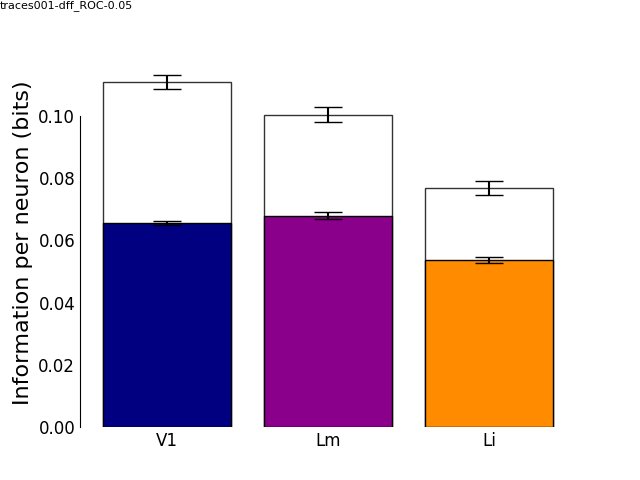

In [157]:
fig, ax = pl.subplots()

# Plot mutual info
means = [midf[midf['visual_area']==vis]['I_rs'].mean() for vis in visual_areas]
std = [spstats.sem(midf[midf['visual_area']==vis]['I_rs']) for vis in visual_areas]

positions=[0, 1, 2]
bars = ax.bar(positions, means, yerr=std, align='center', alpha=0.8, ecolor='black', capsize=10, 
             color='w', linewidth=1, edgecolor='k')

means_non = [midf[midf['visual_area']==vis]['I_rNotL'].mean() for vis in visual_areas]
std_non = [spstats.sem(midf[midf['visual_area']==vis]['I_rNotL']) for vis in visual_areas]

positions=[0, 1, 2]
bars = ax.bar(positions, means_non, yerr=std_non, align='center', alpha=0.5, 
              ecolor='k', capsize=10,
             linewidth=1, edgecolor='k')
for bar, visual_area in zip(bars, visual_areas):
    bar.set_color(area_colors[visual_area])
    bar.set_alpha(1)
    bar.set_linewidth(1)
    bar.set_edgecolor('k')
    
ax.set_xticks(positions) #(visual_areas)
ax.set_xticklabels(visual_areas)
ax.tick_params(axis='both', length=0)
ax.set_ylabel('Information per neuron (bits)')
label_figure(fig, aggr_data_id)

sns.despine(trim=True, bottom=True)

pl.savefig(os.path.join(outdir, 'MI-nonneg_response_stim-v-luminance_split.svg'))
pl.savefig(os.path.join(outdir, 'MI-nonneg_response_stim-v-luminance_split.png'))

#### Stats

In [158]:
# Set up the data for comparison (creates a specialised object)
multiC = MultiComparison(midf['I_rs'], midf['visual_area'])

# Print the comparisons
print(multiC.tukeyhsd().summary())

# holm
#comp = multiC.allpairtest(spstats.ttest_rel, method='Holm')


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower upper  reject
------------------------------------------
  Li     Lm    0.0237  0.014 0.0334  True 
  Li     V1    0.0341  0.025 0.0433  True 
  Lm     V1    0.0104  0.003 0.0179  True 
------------------------------------------


In [159]:
results = do_mannwhitney(midf, metric='I_rs')
for r in results:
    print(r)

Different distribution (reject H0)
Different distribution (reject H0)
Different distribution (reject H0)
(('V1', 'Lm'), True, 7.4186018502158855e-05)
(('V1', 'Li'), True, 3.2858844018841173e-32)
(('Lm', 'Li'), True, 8.3886277985138087e-18)


In [161]:
results = do_mannwhitney(midf, metric='I_rNotL')
for r in results:
    print(r)

Same distribution (fail to reject H0)
Different distribution (reject H0)
Different distribution (reject H0)
(('V1', 'Lm'), False, 0.18491868489838126)
(('V1', 'Li'), True, 9.0326081228459159e-21)
(('Lm', 'Li'), True, 2.4447833503168711e-20)


# Calculate Thr lum-ratios

In [897]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

In [898]:
lumratios_datafile = os.path.join(outdir, 'lum-ratios_M%i-M%i.pkl' % (objectA, objectB))

In [674]:
lumratio_thr = 0.8
objectA = 0 # 53 #0
objectB = 53 #106 #53
object_pair = [objectA, objectB] # only consider A v B

lumdf=[]
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    
    if '%s_%s' % (session, animalid) in always_exclude:
        continue
        
    #currexp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    exps = [e for e in g['experiment'].values if 'rfs' in e]
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    
    for currexp in exps:
        rflums = RFDATA['%s_%s' % (datakey, currexp)].copy()
        rflums['morphlevel'] = [-1 if m=='fullscreen' else int(m[1:]) for m in rflums['object']]

        lum_ratios = []
        for rid, roilums in rflums.groupby(['rid']):
            #print('...%i' % rid)
            mean_A = roilums[roilums['morphlevel']==objectA].mean()['RF_luminance']# mean across views
            mean_B = roilums[roilums['morphlevel']==objectB].mean()['RF_luminance']

            ratio = (mean_A / mean_B) if mean_A < mean_B else (mean_B / mean_A)

            lum_ratios.append(pd.DataFrame({'dim': objectA if mean_A < mean_B else objectB, 
                                            'bright': objectB if mean_A < mean_B else objectA, 
                                            'L_ratio': ratio,
                                            'visual_area': visual_area,
                                            'datakey': datakey,
                                            'experiment': currexp,
                                            'rid': rid}, index=[rid]))
        lumratios = pd.concat(lum_ratios, axis=0)

        lumdf.append(lumratios) #lumratios[lumratios['L_ratio']>=lumratio_thr])

lumdf = pd.concat(lumdf, axis=0)


In [899]:
with open(lumratios_datafile, 'wb') as f:
    pkl.dump(lumdf, f, protocol=pkl.HIGHEST_PROTOCOL)
print(lumratios_datafile)

/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis/lum-ratios_M0-M53.pkl


#### Main objects don't make the threshold of 0.8...

##### Try all object pairs for a session?

In [604]:
animalid='JC084'
session = '20190522'
fovnum = 1
currexp = 'rfs'
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

mlevels = [m for m in morphlevels if m!= -1]
mpairs = list(itertools.combinations(mlevels, 2))


#ldf = []

#currexp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
#exps = [e for e in g['experiment'].values if 'rfs' in e]
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

rflums = RFDATA['%s_%s' % (datakey, currexp)].copy()
rflums['morphlevel'] = [-1 if m=='fullscreen' else int(m[1:]) for m in rflums['object']]

lum_ratios = []
for rid, roilums in rflums.groupby(['rid']):
    for (objectA, objectB) in mpairs:
        #print('...%i' % rid)
        mean_A = roilums[roilums['morphlevel']==objectA].mean()['RF_luminance']# mean across views
        mean_B = roilums[roilums['morphlevel']==objectB].mean()['RF_luminance']

        ratio = (mean_A / mean_B) if mean_A < mean_B else (mean_B / mean_A)

        lum_ratios.append(pd.DataFrame({'dim': objectA if mean_A < mean_B else objectB, 
                                        'bright': objectB if mean_A < mean_B else objectA, 
                                        'L_ratio': ratio,
                                        'visual_area': visual_area,
                                        'datakey': datakey,
                                        'experiment': currexp,
                                        'rid': rid}, index=[rid]))
        
lumratios = pd.concat(lum_ratios, axis=0)

#ldf.append(lumratios) #lumratios[lumratios['L_ratio']>=lumratio_thr])


In [610]:
lumratios[lumratios['L_ratio']>=0.8][['bright', 'dim']]

bright  dim
0         0   14
0         0   27
0         0   40
0        14   27
0        14   40
0        14   53
0        27   40
0        27   53
0        27   66
0        27   79
0        27   92
0        27  106
0        40   53
0        40   66
0        40   79
0        40   92
0        40  106
0        53   66
0        53   79
0        53   92
0        53  106
0        66   79
0        66   92
0        66  106
0        79   92
0        79  106
0        92  106
1         0   14
1         0   27
1         0   40
..      ...  ...
258      79  106
258      92  106
259       0   14
259       0   27
259       0   40
259       0   53
259      14   27
259      14   40
259      14   53
259      14   66
259      27   40
259      27   53
259      27   66
259      27   79
259      27   92
259      40   53
259      40   66
259      40   79
259      40   92
259      40  106
259      53   66
259      53   79
259      53   92
259      53  106
259      66   79
259      66   92
259      66  106
259      79   92
259      79  106
259      92  106

[4968 rows x 2 columns]

In [609]:
lumratios.min()

L_ratio                   0.675666
bright                           0
datakey        20190522_JC084_fov1
dim                              0
experiment                     rfs
rid                              0
visual_area                     V1
dtype: object

In [675]:
lumdf.groupby(['visual_area']).count()

L_ratio  bright  datakey   dim  experiment   rid
visual_area                                                  
Li               929     929      929   929         929   929
Lm              1208    1208     1208  1208        1208  1208
V1              2484    2484     2484  2484        2484  2484

In [513]:
lumdf['L_ratio'].min()

0.62790748136595465

<IPython.core.display.Javascript object>


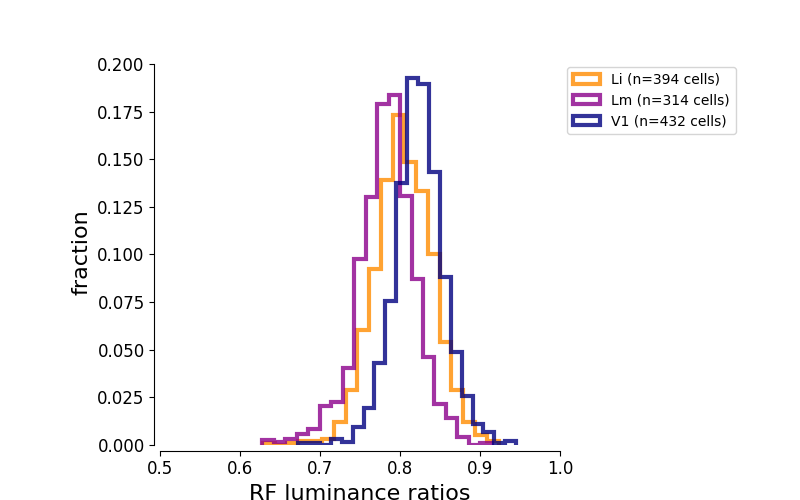

(0, 53)


In [820]:
cdf=False
fig, ax = pl.subplots(figsize=(8,5))
for visual_area, g in lumdf.groupby(['visual_area']):
    n_rois = len(g['rid'].unique())
#     sns.distplot(g['L_ratio'], color=area_colors[visual_area], ax=ax,
#                  norm_hist=True, kde=False,
#                  kde_kws={"alpha":0},#{"color": "k", "lw": 3, "label": "KDE"},
#                  hist_kws={"histtype": "step", "linewidth": 3,
#                             "alpha": 1, "color": area_colors[visual_area],
#                           "label": '%s (n=%i cells)' % (visual_area, n_rois)})
    
    values = g['L_ratio'].values
    weights = np.ones_like(values)/float(len(values))

    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i cells)' % (visual_area, n_rois),
            color=area_colors[visual_area],
            histtype='step', alpha=0.8, lw=3,
            normed=0, weights=weights, bins=20)
    
ax.set_ylabel('fraction')
ax.set_xlabel('RF luminance ratios')
ax.legend(bbox_to_anchor=(1, 1)) #, ncol=3)
ax.set_xlim([0.5, 1])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(left=0.2, right=0.7)

cdf_str = '_cdf' if cdf else ''
pl.savefig(os.path.join(outdir, 'distn-RF-luminance-ratios_M%i-M%i%s.svg' %(objectA, objectB, cdf_str)))
print(objectA, objectB)

In [721]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

#### Plot I(R; O) vs. LR *for object pair*

In [724]:
ldfs = []
ii = 0
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if '%s_%s' % (session, animalid) in always_exclude:
        continue
        
    fov = 'FOV%i_zoom2p0x' % fovnum #int(fovn[3:])
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    
    # Blob trial metrics
    neuraldata = DATA['%s' % datakey]['data'].copy()
    # indices should be trial_nums
    # 'config' is last column
    sdf = DATA[datakey]['sdf']

    # RF fit data
    #g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs' if 'rfs' in g['experiment'].values else 'rfs10'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # RF luminance data
    rflums = RFDATA['%s_%s' % (datakey, curr_exp)].copy()
    rflums['morphlevel'] = [int(m[1:]) if 'M' in m else -1 for m in rflums['object']]
    rflums.index =  [sdf[(sdf['size']==sz) & (sdf['morphlevel']==ml)].index[0]\
                       for sz, ml in zip(rflums['size'].values, rflums['morphlevel'].values)]   
    rois_objects = [int(r) for r in neuraldata.columns.tolist() if r!='config']

    # Get ROIs for both
    print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    print("%i rois common to both." % len(roi_list))

    # Calculate I(R;S)
    print("--- calculating MI for each cell ---")

    for rid in roi_list:
        tmpd = pd.DataFrame(neuraldata[[rid, 'config']].values, columns=['dff', 'config'], \
                            index=neuraldata[rid].index)
        tmprf = rflums[rflums['rid']==rid].copy()

        currcfgs = sdf[sdf['morphlevel'].isin([objectA, objectB])].index.tolist()
        tmpd = tmpd[tmpd['config'].isin(currcfgs)]
        tmprf = tmprf[tmprf['morphlevel'].isin([objectA, objectB])]

        #### Create joint distribution for RESPONSE and STIMULUS.
        tmpd = populate_bins(tmpd, rkey='dff', n_bins=n_bins)                             
        state_counts = tmpd.groupby(['config', 'bin']).size().reset_index(name='count')
        ntrial_total = float(tmpd.shape[0])
        #jointd = state_counts.pivot(index='config', columns='bin', values='count') / ntrial_total
        #### Calculate I(R;S)
        I_rs = get_mi(state_counts, ntrial_total, a='bin', b='config')
        #print(I_rs)

        # THIS DOESNT WORK. ALL 0s or SAME VALUE, depending on bins
        # Calculate MI(R; O) for this object pair
        # tmprf = rflums[(rflums['rid']==rid) & (rflums['morphlevel'].isin(object_pair))].copy()
        # tmprf = rflums[(rflums['rid']==rid) ].copy()

        # tmprf = populate_bins(tmprf, rkey='RF_luminance', n_bins=3)
        # state_counts = tmprf.groupby(['bin', 'morphlevel']).size().reset_index(name='count')
        # ntrials_curr = state_counts['count'].sum()
        # I_lo_curr = get_mi(state_counts, ntrials_curr, a='morphlevel', b='bin')
        # print(I_lo_curr)

        #### Create joint distribution for RESPONSE and OBJECT.
        tmpd['object'] = [sdf['morphlevel'][cfg] for cfg in tmpd['config']]
        state_counts = tmpd.groupby(['object', 'bin']).size().reset_index(name='count')
        #jointd = state_counts.pivot(index='config', columns='bin', values='count') / ntrial_total
        #### Calculate I(R;O)
        I_ro = get_mi(state_counts, ntrial_total, a='bin', b='object')
        #print(I_ro)

        LR = float(lumdf[ (lumdf['datakey']==datakey) & (lumdf['rid']==rid) & (lumdf['experiment']==curr_exp)]['L_ratio'])

        ldfs.append(pd.DataFrame({'LR': LR, 'I_ro': I_ro, 'I_rs': I_rs, 'visual_area': visual_area,
                                 'datakey': datakey, 'rid': rid}, index=[ii]))
        ii += 1
ldfs = pd.concat(ldfs, axis=0)

... [JC076|20190502|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 60, RFs: 63
22 rois common to both.
--- calculating MI for each cell ---
... [JC090|20190605|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 141, RFs: 33
20 rois common to both.
--- calculating MI for each cell ---
... [JC091|20190602|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 161, RFs: 93
55 rois common to both.
--- calculating MI for each cell ---
... [JC091|20190606|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... l

... [JC084|20190522|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 100, RFs: 165
84 rois common to both.
--- calculating MI for each cell ---
... [JC085|20190622|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 225, RFs: 236
183 rois common to both.
--- calculating MI for each cell ---
... [JC097|20190613|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 116, RFs: 153
96 rois common to both.
--- calculating MI for each cell ---
... [JC097|20190616|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fit

<IPython.core.display.Javascript object>


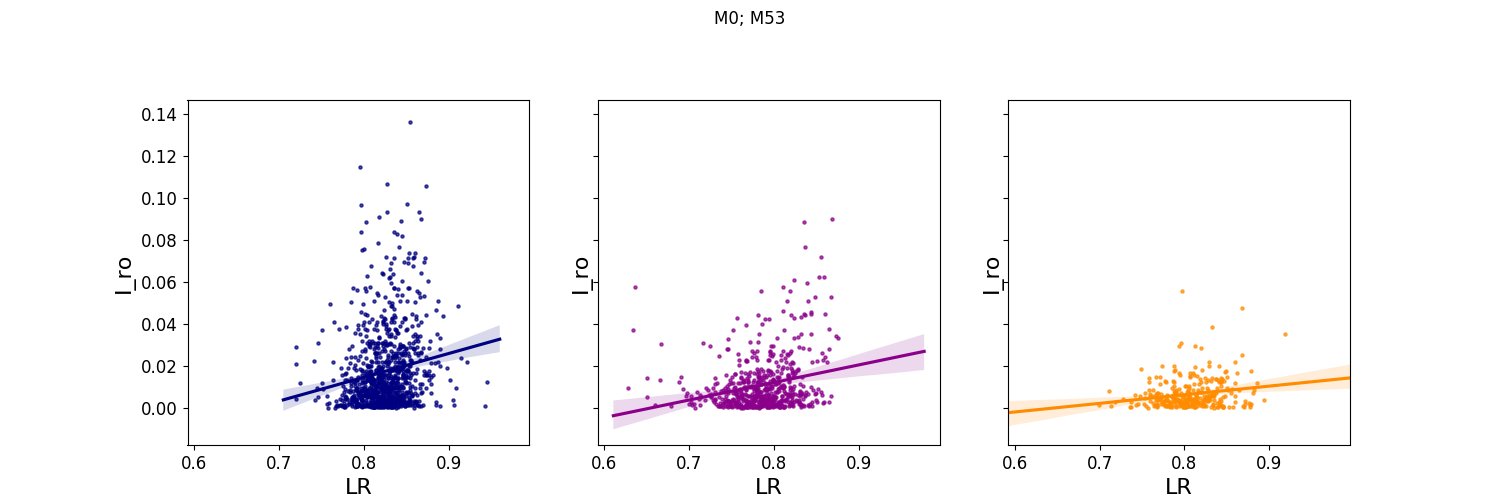

In [760]:
fig, axes = pl.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
i=0
for visual_area in visual_areas:
    g = ldfs[ldfs['visual_area']==visual_area]
    #axes[i].scatter(g['LR'], g['I_ro'], color=area_colors[visual_area], s=5, alpha=0.7)
    sns.regplot(g['LR'], g['I_ro'], color=area_colors[visual_area],
                scatter_kws={"s": 5, 'alpha': 0.7, 'color': area_colors[visual_area]}, ax=axes[i])
    i+=1
    
figexps.suptitle("M%i; M%i" % (objectA, objectB))
pl.subplots_adjust(wspace=0.2, top=0.8)
pl.savefig(os.path.join(outdir, 'MI-RO_vers_lum-ratio_by-area_M%i-M%i.svg' % (objectA, objectB)))


#### Bin LR

<IPython.core.display.Javascript object>


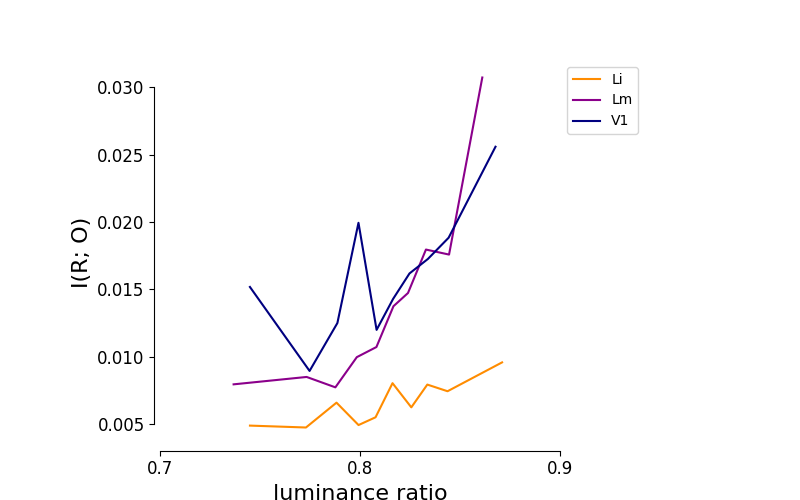

In [818]:
nbins=10
ldfs['bin'] = pd.qcut(ldfs['LR'], q=nbins,labels=['bin%i' % i for i in np.arange(0, nbins)])

fig, ax = pl.subplots(figsize=(8,5))
for visual_area, g in ldfs.groupby(['visual_area']):
    meanlr = [binvs['LR'].mean() for b, binvs in g.groupby(['bin'])]
    vals_in_bin = [binvs['I_ro'].mean() for b, binvs in g.groupby(['bin'])]
    bin_vals = [int(b[3:]) for b, binvs in g.groupby(['bin'])]
    ax.plot(meanlr, vals_in_bin, color=area_colors[visual_area], label=visual_area)
    #ax.st_xticks(bin_vals)

#ax.set_xticks(np.linspace(bin_vals[0], bin_vals[-1], 3))
#ax.set_xticklabels(np.linspace(meanlr[0], meanlr[-1], 3))
ax.legend(bbox_to_anchor=(1.0, 1))
ax.set_xticks(np.linspace(0.7, 0.9, 3))
#ax.set_xticklabels(np.linspace(0.6, 1.0, 4))
sns.despine(trim=True, offset=4)

ax.set_ylabel('I(R; O)')
ax.set_xlabel('luminance ratio')

pl.subplots_adjust(left=0.2, right=0.7)
pl.savefig(os.path.join(outdir, 'MI-RO_vers_lum-ratio_binned-%i_M%i-M%i.svg' % (nbins, objectA, objectB)))


In [744]:
np.linspace(0.6, 1.0, 4)

array([ 0.6       ,  0.73333333,  0.86666667,  1.        ])

## Calculate overlap bw object and RF

In [780]:

from matplotlib.patches import Ellipse, Rectangle, Polygon
from shapely.geometry.point import Point
from shapely.geometry import box
from shapely import affinity
from shapely.ops import cascaded_union

def create_ellipse(center, lengths, angle=0):
    """
    create a shapely ellipse. adapted from
    https://gis.stackexchange.com/a/243462
    """
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr

def rfs_to_polys(rffits, sigma_scale=2.35):
    '''
    rffits (pd dataframe)
        index : roi indices (same as gdf.rois)
        columns : r2, sigma_x, sigma_y, theta, x0, y0 (already converted) 
        
    '''
    rf_polys=[]
    for roi in rffits.index.tolist():
        _, sx, sy, th, x0, y0 = rffits.loc[roi]
        s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale, abs(sy)*sigma_scale), np.rad2deg(th))
        rf_polys.append(s_ell)
    return rf_polys

def stimsize_poly(sz, xpos=0, ypos=0):
    
    ry_min = ypos - sz/2.
    rx_min = xpos - sz/2.
    ry_max = ypos + sz/2.
    rx_max = xpos + sz/2.
    s_blobs = box(rx_min, ry_min, rx_max, ry_max)
    
    return s_blobs

from pipeline.python.retinotopy import fit_2d_rfs as fitrf


In [985]:
def get_stim_info(animalid, session, fov):

    stiminfo = rfutils.get_screen_info(animalid, session, fov)
    screen_bounds = [stiminfo['linminH'], stiminfo['linminW'], stiminfo['linmaxH'], stiminfo['linmaxW']]
    screen_aspect = stiminfo['resolution'][0] / float(stiminfo['resolution'][1])

    screen_width_deg = stiminfo['linmaxW']*2.
    screen_height_deg = stiminfo['linmaxH']*2.

    pix_per_degW = stiminfo['resolution'][0] / screen_width_deg
    pix_per_degH = stiminfo['resolution'][1] / screen_height_deg 

    #print(pix_per_degW, pix_per_degH)
    pix_per_deg = np.mean([pix_per_degW, pix_per_degH])
    print("avg pix/deg: %.2f" % pix_per_deg)
    
    stiminfo = {'stimulus_sizes': sorted(sdf['size'].unique()),
                'screen_bounds': screen_bounds,
                'screen_aspect': screen_aspect,
                'pix_per_deg': pix_per_deg,
                'stimulus_xpos': stiminfo['stim_pos'][0],
                'stimulus_ypos': stiminfo['stim_pos'][1]}
    return stiminfo


In [1037]:
def get_RF_ellipse_params(rfstats, roi_list=None, return_deg=False):
    if roi_list is None:
        roi_list = rfstats.keys()
    
    #stiminfo = get_stim_info(animalid, session, fov)
    rffits = fitrf.rfits_to_df(rfstats['fit_results'], 
                                row_vals=rfstats['row_vals'],
                                col_vals=rfstats['col_vals'],
                                roi_list=sorted(roi_list))
    if return_deg:
        thetas = [np.rad2deg(th) % 360. for th in rffits['theta']]
        rffits['theta'] = thetas

        
    return rffits

In [982]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

def get_overlaps(rfstats, stiminfo, roi_list=None):
    if roi_list is None:
        roi_list = rfstats.keys()
    
    #stiminfo = get_stim_info(animalid, session, fov)
    rffits = fitrf.rfits_to_df(rfstats['fit_results'], 
                                row_vals=rfstats['row_vals'],
                                col_vals=rfstats['col_vals'],
                                roi_list=sorted(roi_list))
    
    rf_polys = rfs_to_polys(rffits)

    # Create shapes for each stim size (bounding box)
    stim_polys = [stimsize_poly(blob_sz, xpos=stiminfo['stimulus_xpos'], ypos=stiminfo['stimulus_ypos'])\
                  for blob_sz in stiminfo['stimulus_sizes']]
    stim_labels = ['%i' % blob_sz for blob_sz in stiminfo['stimulus_sizes']]

    ## Caculate overlaps and put into dataframe
    overlaps=[]
    for s_label, s_poly in zip(stim_labels, stim_polys):
        tdf = pd.DataFrame({'overlap': [(s_ell.intersection(s_poly)).area / s_ell.area \
                                   for s_ell in rf_polys],
                            #'distance': rf_dist_from_center,
                            'size': [s_label for _ in range(len(rf_polys))],
                            'rid': roi_list})
        overlaps.append(tdf)

    overlaps = pd.concat(overlaps, axis=0)
    
    return overlaps


In [901]:
overlaps_datafile = os.path.join(outdir, 'overlaps-all-RFs.pkl')

In [827]:
overlaprois=[]
for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    
    if '%s_%s' % (session, animalid) in always_exclude:
        continue
        
    datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    fov = 'FOV%i_zoom2p0x' % fovnum

    # Blob trial metrics
    neuraldata = DATA['%s' % datakey]['data'].copy()
    sdf = DATA[datakey]['sdf']

    # ROI list for objects
    rois_objects = np.array([int(i) for i in DATA['%s' % datakey]['data'].columns.tolist() if i!='config'])
    sizes = sorted(sdf['size'].unique())
    morphlevels = sizes = sorted(sdf['morphlevel'].unique())

    # RF fit data
    #g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs' if 'rfs' in g['experiment'].values else 'rfs10'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # Get ROIs for both
    #print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    #print("%i rois common to both." % len(roi_list))
    
    stiminfo = get_stim_info(animalid, session, fov)
    overlaps = get_overlaps(rfstats, stiminfo, roi_list=roi_list)

    #mean_overlaps = overlaps.groupby(['rid']).mean()
    #pass_rois = mean_overlaps[mean_overlaps['overlap']>=0.5].index.tolist()
    #print("===== %s: %i of %i pass. =====" % (datakey, len(pass_rois), len(mean_overlaps)))

    ns = overlaps.shape[0]
    overlaps['visual_area'] = [visual_area for _ in np.arange(0, ns)]
    overlaps['datakey'] = [datakey for _ in np.arange(0, ns)]

    overlaprois.append(overlaps)

overlaprois = pd.concat(overlaprois, axis=0)


... [JC076|20190502|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
[JC076] 20190502 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC076|20190502|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
[JC076|20190502] No experiment exists for: gratings
Stimuli presented at coords: (-5, 8)
... [JC090|20190605|FOV1_zoom2p0x] creating rfs10 object
... getting data paths - name: rfs10
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
[JC090] 20190605 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC090|20190605|FOV1_z

... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC120|20191111|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC120|20191111|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (30, -5)
... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
[JC078] 20190430 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC078|20190430|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
[JC078|20190430] No experiment exists for: gratings
Stimuli presented a

... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC076|20190501|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
[JC076|20190501] No experiment exists for: gratings
Stimuli presented at coords: (30, 0)
... [JC083|20190507|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
[JC083] 20190507 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC083 | 20190507 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
[JC083|20190507] No experiment exists for: gratings
Stimuli presented at coords: (20, 5)
... [JC083|20190510|FOV1_zoom2p0x] creati

In [902]:
with open(overlaps_datafile, 'wb') as f:
    pkl.dump(overlaprois, f, protocol=pkl.HIGHEST_PROTOCOL)
print(overlaps_datafile)


/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis/overlaps-all-RFs.pkl


<IPython.core.display.Javascript object>


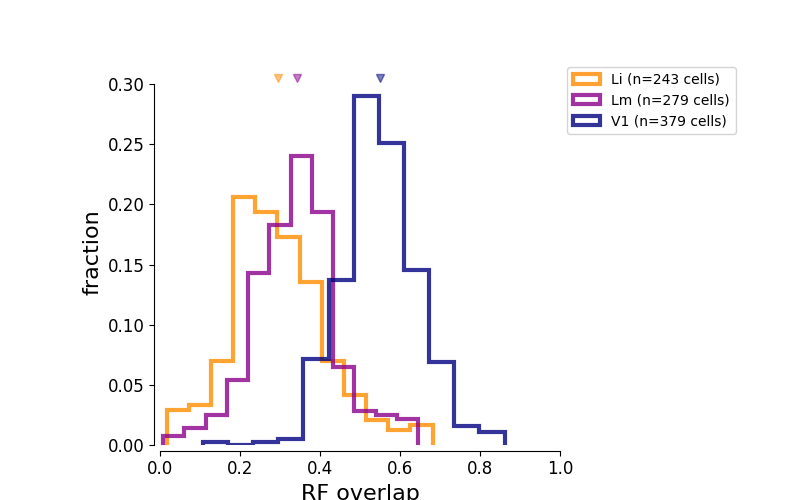

(0, 53)


In [838]:
# fig, axes = pl.subplots(1,3)
# i=0
# for visual_area, od in overlaprois.groupby(['visual_area']):
    
#     mean_overlaps = od.groupby(['rid']).mean()
#     sns.distplot(mean_overlaps, color=area_colors[visual_area], ax=axes[i])
#     i+=1

cdf=False
fig, ax = pl.subplots(figsize=(8,5)) #figsize=(8,5))
for visual_area, g in overlaprois.groupby(['visual_area']):
    n_rois = len(g['rid'].unique())
    values = g.groupby(['rid']).mean().values
    weights = np.ones_like(values)/float(len(values))

    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i cells)' % (visual_area, n_rois),
            color=area_colors[visual_area],
            histtype='step', alpha=0.8, lw=3,
            normed=0, weights=weights, bins=12)
    
# Draw means
mean_marker = 'v'
curr_ymax = ax.get_ylim()[-1]
for visual_area, g in overlaprois.groupby(['visual_area']):
    mean_val = g.groupby(['rid']).mean().values.mean()
    ax.plot(mean_val, curr_ymax, marker=mean_marker, color=area_colors[visual_area],
           alpha=0.5)
            
ax.set_ylabel('fraction')
ax.set_xlabel('RF overlap')
ax.legend(bbox_to_anchor=(1, 1)) #, ncol=3)
ax.set_xlim([0, 1])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(left=0.2, right=0.7)

cdf_str = '_cdf' if cdf else ''
pl.savefig(os.path.join(outdir, 'distn-RF-overlaps_size-bb%s.svg' %(cdf_str)))
print(objectA, objectB)


[0.29121999283338346,
 0.24889912661503882,
 0.22450216158284858,
 0.3112540575169872,
 0.07960553829525978,
 0.2767611814663546,
 0.1603456662238229,
 0.3005555965986142,
 0.4321308074543299,
 0.4043166662561501,
 0.3160706863210526,
 0.3268178891659256,
 0.4604349312720564,
 0.3464197759073486,
 0.6470913471954314,
 0.3085027274794422,
 0.4246929747721723,
 0.2862003776452618,
 0.5222613308408021,
 0.29676159932193896,
 0.2587703385026276,
 0.2691798102919823,
 0.3386933618146014,
 0.3958477490247366,
 0.4018844791016375,
 0.38249877789768016,
 0.31950470735194775,
 0.35071395903357105,
 0.5631491653856338,
 0.32318163484329665,
 0.24686458911092543,
 0.3946613334061797,
 0.46259065296755786,
 0.3786545439814294,
 0.25735130411654616,
 0.3564300562309153,
 0.33254889814079325,
 0.33113659411767393,
 0.32978738765035215,
 0.23562837612084384,
 0.19441579257246588,
 0.31511939133645966,
 0.2505717332233049,
 0.256269717268346,
 0.13754808639292365,
 0.19853260856514415,
 0.038745357724

In [822]:
from sklearn.model_selection import train_test_split
import scipy.stats as spstats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [823]:
print(datakey)
lumdf.groupby(['visual_area', 'datakey']).count()

20191006_JC110_fov1


L_ratio  bright  dim  experiment  rid
visual_area datakey                                                   
Li          20190502_JC076_fov1       63      63   63          63   63
            20190602_JC091_fov1      198     198  198         198  198
            20190605_JC090_fov1       33      33   33          33   33
            20190606_JC091_fov1       65      65   65          65   65
            20190607_JC091_fov1      115     115  115         115  115
            20190609_JC099_fov1       70      70   70          70   70
            20190612_JC099_fov1       73      73   73          73   73
            20190614_JC091_fov1      125     125  125         125  125
            20190617_JC099_fov1       30      30   30          30   30
            20191008_JC091_fov1       70      70   70          70   70
            20191018_JC113_fov1       37      37   37          37   37
            20191105_JC117_fov1       31      31   31          31   31
            20191111_JC120_fov1       19      19   19          19   19
Lm          20190430_JC078_fov1      152     152  152         152  152
            20190504_JC078_fov1       75      75   75          75   75
            20190506_JC080_fov1      105     105  105         105  105
            20190508_JC083_fov1      131     131  131         131  131
            20190509_JC078_fov1       76      76   76          76   76
            20190512_JC083_fov1      146     146  146         146  146
            20190513_JC078_fov1      102     102  102         102  102
            20190517_JC083_fov1       97      97   97          97   97
            20190525_JC084_fov1      113     113  113         113  113
            20190603_JC080_fov1      145     145  145         145  145
            20190627_JC091_fov1       66      66   66          66   66
V1          20190420_JC076_fov1      160     160  160         160  160
            20190501_JC076_fov1      102     102  102         102  102
            20190507_JC083_fov1      134     134  134         134  134
            20190510_JC083_fov1      116     116  116         116  116
            20190511_JC083_fov1      107     107  107         107  107
            20190522_JC084_fov1      165     165  165         165  165
            20190613_JC097_fov1      284     284  284         284  284
            20190616_JC097_fov1      427     427  427         427  427
            20190617_JC097_fov1      260     260  260         260  260
            20190622_JC085_fov1      389     389  389         389  389
            20191006_JC110_fov1      340     340  340         340  340

In [865]:
print(len(curr_lumdf[curr_lumdf['experiment']=='rfs']['rid'].unique()))
print(len(curr_lumdf[curr_lumdf['experiment']=='rfs10']['rid'].unique()))


190
150


In [946]:
lumdf

L_ratio  bright              datakey  dim experiment  rid visual_area
0    0.748437       0  20190502_JC076_fov1   53        rfs    0          Li
2    0.773429       0  20190502_JC076_fov1   53        rfs    2          Li
4    0.783395       0  20190502_JC076_fov1   53        rfs    4          Li
5    0.801559       0  20190502_JC076_fov1   53        rfs    5          Li
6    0.758175       0  20190502_JC076_fov1   53        rfs    6          Li
7    0.768317       0  20190502_JC076_fov1   53        rfs    7          Li
8    0.782965       0  20190502_JC076_fov1   53        rfs    8          Li
9    0.768519       0  20190502_JC076_fov1   53        rfs    9          Li
11   0.789198       0  20190502_JC076_fov1   53        rfs   11          Li
13   0.748773       0  20190502_JC076_fov1   53        rfs   13          Li
15   0.786723       0  20190502_JC076_fov1   53        rfs   15          Li
17   0.775453       0  20190502_JC076_fov1   53        rfs   17          Li
20   0.765910       0  20190502_JC076_fov1   53        rfs   20          Li
23   0.790223       0  20190502_JC076_fov1   53        rfs   23          Li
24   0.768191       0  20190502_JC076_fov1   53        rfs   24          Li
28   0.773191       0  20190502_JC076_fov1   53        rfs   28          Li
47   0.757967       0  20190502_JC076_fov1   53        rfs   47          Li
61   0.765631       0  20190502_JC076_fov1   53        rfs   61          Li
63   0.756788       0  20190502_JC076_fov1   53        rfs   63          Li
67   0.748026       0  20190502_JC076_fov1   53        rfs   67          Li
68   0.769395       0  20190502_JC076_fov1   53        rfs   68          Li
71   0.723767       0  20190502_JC076_fov1   53        rfs   71          Li
76   0.767781       0  20190502_JC076_fov1   53        rfs   76          Li
82   0.717596       0  20190502_JC076_fov1   53        rfs   82          Li
84   0.745746       0  20190502_JC076_fov1   53        rfs   84          Li
99   0.762553       0  20190502_JC076_fov1   53        rfs   99          Li
107  0.771861       0  20190502_JC076_fov1   53        rfs  107          Li
112  0.738376       0  20190502_JC076_fov1   53        rfs  112          Li
113  0.743982       0  20190502_JC076_fov1   53        rfs  113          Li
114  0.747103       0  20190502_JC076_fov1   53        rfs  114          Li
..        ...     ...                  ...  ...        ...  ...         ...
299  0.816557       0  20191006_JC110_fov1   53      rfs10  299          V1
301  0.776867       0  20191006_JC110_fov1   53      rfs10  301          V1
302  0.824265       0  20191006_JC110_fov1   53      rfs10  302          V1
303  0.816201       0  20191006_JC110_fov1   53      rfs10  303          V1
305  0.822369       0  20191006_JC110_fov1   53      rfs10  305          V1
308  0.821909       0  20191006_JC110_fov1   53      rfs10  308          V1
310  0.835142       0  20191006_JC110_fov1   53      rfs10  310          V1
312  0.830659       0  20191006_JC110_fov1   53      rfs10  312          V1
313  0.851399       0  20191006_JC110_fov1   53      rfs10  313          V1
314  0.802563       0  20191006_JC110_fov1   53      rfs10  314          V1
315  0.754846       0  20191006_JC110_fov1   53      rfs10  315          V1
320  0.824344       0  20191006_JC110_fov1   53      rfs10  320          V1
323  0.821437       0  20191006_JC110_fov1   53      rfs10  323          V1
329  0.841165       0  20191006_JC110_fov1   53      rfs10  329          V1
336  0.851806       0  20191006_JC110_fov1   53      rfs10  336          V1
338  0.844876       0  20191006_JC110_fov1   53      rfs10  338          V1
344  0.828369       0  20191006_JC110_fov1   53      rfs10  344          V1
346  0.784947       0  20191006_JC110_fov1   53      rfs10  346          V1
347  0.775737       0  20191006_JC110_fov1   53      rfs10  347          V1
350  0.825509       0  20191006_JC110_fov1   53      rfs10  350          V1
351  0.776549       0  20191006_JC110_fov1   53      r

In [912]:
overlap_thr=0.25
luminance_thr=0.8

# First get only Object A and B trials
m0 = objectA
m100 = objectB #106
C_value = 1
    
df = []
i=0
for (visual_area, datakey), g in lumdf.groupby(['visual_area', 'datakey']): #'datakey']):

    sdf =  DATA[datakey]['sdf'].copy()
    object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
    sizes = sorted(stimdf['size'].unique())

    # Select subset of data
    sample_labels = DATA[datakey]['data']['config'].copy()
    included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
    sample_data = DATA[datakey]['data'].loc[included_trial_nums].copy()
    orig_rois = [int(r) for r in sample_data.columns if r!='config']

    # Get labels
    targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
    targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

    # Get ROIs with RF fits and threshold by lum-ratio
    curr_lumdf = lumdf[lumdf['datakey']==datakey]
    rfexp = 'rfs' if 'rfs' in curr_lumdf['experiment'].unique() else 'rfs10'
    meanlrs = curr_lumdf[curr_lumdf['experiment']==rfexp].groupby(['rid']).mean()
    lum_rois = meanlrs[meanlrs['L_ratio']>=luminance_thr].index.tolist()
    pass_rois_lum = [r for r in lum_rois if r in orig_rois]

    # Get ROIs with RF fits and threshold by overlap-percentage
    meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
    coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
    pass_rois_overlap = [r for r in coverage_rois if r in orig_rois]
    
    print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
    curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
    print("[%s] %i rois common to both." % (visual_area, len(curr_rois)))    
    
    for rid in curr_rois:

        results = []
        chance_results=[]
        for n_iter in np.arange(0, 50):

            # Equalize df/f across neurons:  Normalize each neuron to have 
            # the same (zero) mean and (unit) SD across the Ms stimuli
            zdata = (sample_data[rid] - sample_data[rid].mean()) / sample_data[rid].std() # zscore each neuron

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            for sz in sizes:
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials].values
                yi = targets.loc[curr_trials]['label'].values

                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)

            #print('---')
            train_data = np.hstack(train_data).reshape(-1, 1)
            train_labels = np.hstack(train_labels)
            #print("Train:", train_data.shape, train_labels.shape)
            test_data = np.hstack(test_data).reshape(-1, 1)
            test_labels = np.hstack(test_labels)
            #print("Test:", test_data.shape, test_labels.shape)

            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=3,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())
            results.append(pd.DataFrame(iterdict, index=[n_iter]))

        ddf = pd.concat(results, axis=0)

        results_across_iters = dict(ddf.mean()) # Save mean results across n_iterations
        results_across_iters.update({'datakey': datakey, 'rid': rid, 'visual_area': visual_area})

        df.append(pd.DataFrame(results_across_iters, index=[i]))
        i+=1
    
df = pd.concat(df, axis=0)

RF-lum-thr: 2/4, Overlap-thr: 14/14
[Li] 2 rois common to both.
RF-lum-thr: 41/66, Overlap-thr: 40/40
[Li] 32 rois common to both.
RF-lum-thr: 16/25, Overlap-thr: 10/10
[Li] 9 rois common to both.
RF-lum-thr: 13/39, Overlap-thr: 14/14
[Li] 11 rois common to both.
RF-lum-thr: 25/80, Overlap-thr: 27/27
[Li] 20 rois common to both.
RF-lum-thr: 14/32, Overlap-thr: 20/20
[Li] 13 rois common to both.
RF-lum-thr: 17/46, Overlap-thr: 20/20
[Li] 15 rois common to both.
RF-lum-thr: 31/64, Overlap-thr: 38/38
[Li] 22 rois common to both.
RF-lum-thr: 3/24, Overlap-thr: 2/2
[Li] 2 rois common to both.
RF-lum-thr: 20/38, Overlap-thr: 9/9
[Li] 7 rois common to both.
RF-lum-thr: 4/20, Overlap-thr: 4/4
[Li] 2 rois common to both.
RF-lum-thr: 1/13, Overlap-thr: 2/2
[Li] 0 rois common to both.
RF-lum-thr: 5/10, Overlap-thr: 2/2
[Li] 2 rois common to both.
RF-lum-thr: 38/77, Overlap-thr: 42/42
[Lm] 25 rois common to both.
RF-lum-thr: 1/2, Overlap-thr: 25/25
[Lm] 0 rois common to both.
RF-lum-thr: 3/5, Over

In [907]:
# for (v, dkey), g in df.groupby(['visual_area', 'datakey']):
    
#     print(v, dkey, len(g[g['test_accuracy'] >=0.6]))



<IPython.core.display.Javascript object>


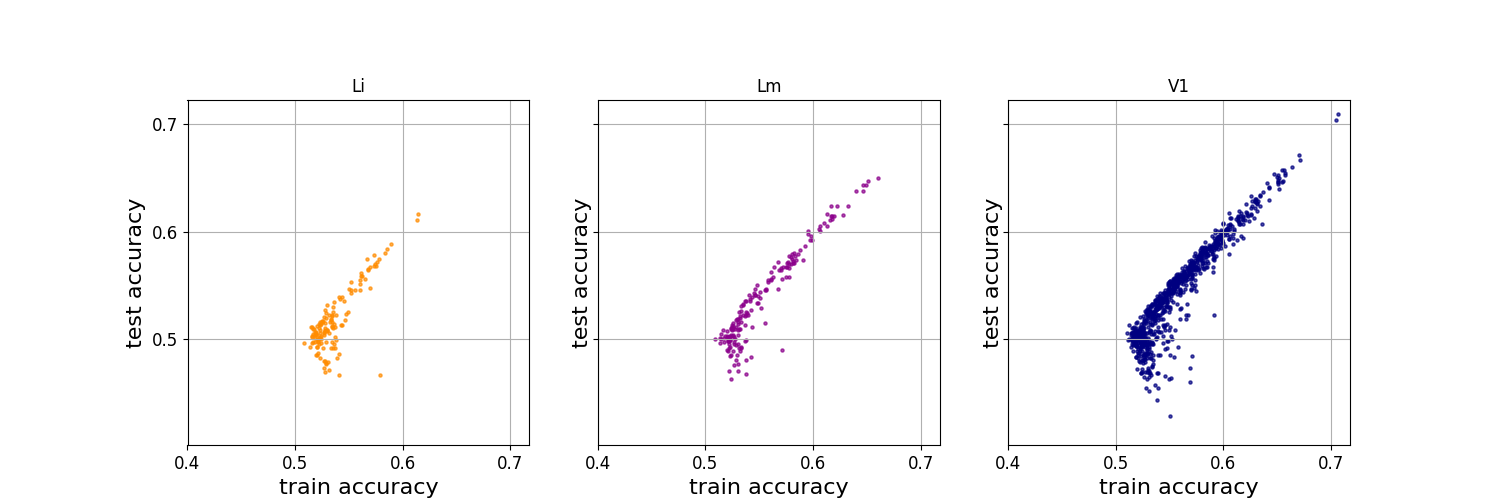

(0, 53)
generalization_train-test-accuracy-C1.00__M0-M53_lum-0.80-overlap-0.25_50iters_scatter


In [947]:
cdf=True

i = 0
fig, axes = pl.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True) #figsize=(8,5))
for visual_area, g in df.groupby(['visual_area']):

    ax=axes[i]
    
    values1 = g['train_accuracy'].values
    values2 = g['test_accuracy'].values

    ax.set_xlabel('train accuracy')
    ax.set_ylabel('test accuracy')
    ax.scatter(values1, values2, color=area_colors[visual_area],
              alpha=0.7, s=5)
    ax.set_title(visual_area)
    
    i += 1
    
vmin=0.4
vmax=0.7
for ax in axes.flat:
    #ax.set_xlim([vmin, vmax])
    ax.set_xticks(np.linspace(vmin, vmax, 4))
    ax.set_xticklabels(np.linspace(vmin, vmax, 4))

    #ax.set_ylim([vmin, vmax])
    ax.set_yticks(np.linspace(vmin, vmax, 4))
    ax.set_yticklabels(np.linspace(vmin, vmax, 4))

    ax.set_aspect('equal')
    ax.grid(True)

figname = 'generalization_train-test-accuracy-C%.2f__M%i-M%i_lum-%.2f-overlap-%.2f_50iters_scatter' % (C_value, m0, m100, luminance_thr, overlap_thr)
pl.subplots_adjust(top=0.8)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

print(objectA, objectB)
    
print(figname)

<IPython.core.display.Javascript object>


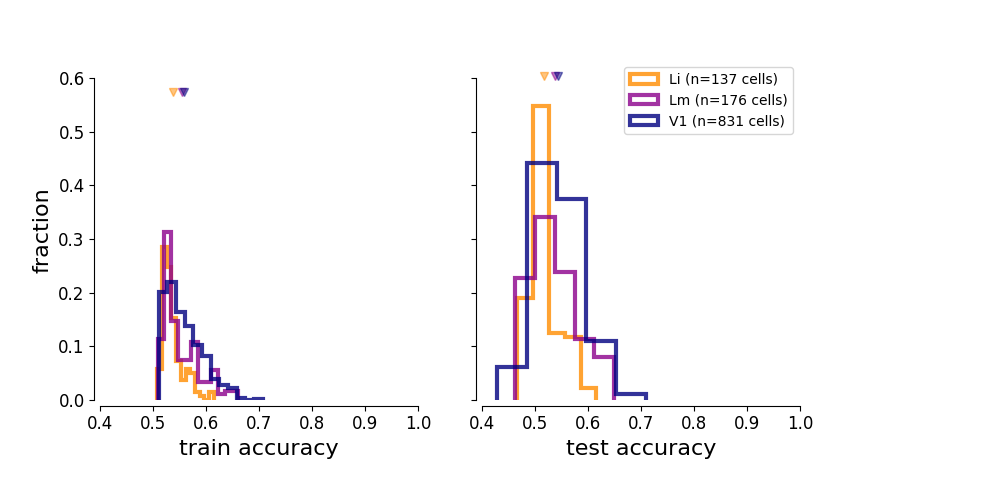

(0, 53)
generalization_train-test-accuracy-C1.00__M0-M53_lum-0.80-overlap-0.25_50iters_


In [1009]:
cdf=False

fig, axes = pl.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True) #figsize=(8,5))
for visual_area, g in df.groupby(['visual_area']):

    ax=axes[0]
    values = g['train_accuracy'].values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i cells)' % (visual_area, n_rois),
            color=area_colors[visual_area],
            histtype='step', alpha=0.8, lw=3,
            normed=0, weights=weights, bins=12)
    ax.set_xlabel('train accuracy')
    
    ax=axes[1]
    values = g['test_accuracy'].values
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=cdf,
            label='%s (n=%i cells)' % (visual_area, len(values)),
            color=area_colors[visual_area],
            histtype='step', alpha=0.8, lw=3,
            normed=0, weights=weights, bins=5)
    ax.set_xlabel('test accuracy')
    
    
# Draw means
mean_marker = 'v'
for ai, ax in enumerate(axes.flat):
    curr_ymax = ax.get_ylim()[-1]
    metric = 'train_accuracy' if ai==0 else 'test_accuracy'
    for visual_area, g in df.groupby(['visual_area']):
        mean_val = g[metric].values.mean()
        ax.plot(mean_val, curr_ymax, marker=mean_marker, color=area_colors[visual_area],
               alpha=0.5)
            
ylabel = 'cdf' if cdf else 'fraction'
axes[0].set_ylabel(ylabel)
#ax.set_xlabel('RF overlap')
ax.legend(bbox_to_anchor=(1, 1)) #, ncol=3)
ax.set_xlim([0.4, 1])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2)

cdf_str = '_cdf' if cdf else ''

figname = 'generalization_train-test-accuracy-C%.2f__M%i-M%i_lum-%.2f-overlap-%.2f_50iters_%s' % (C_value, m0, m100, luminance_thr, overlap_thr, cdf_str)

pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

print(objectA, objectB)
    
print(figname)

In [895]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

In [953]:
df[df['visual_area']=='V1'].groupby(['datakey']).count()

fit_time  rid  score_time  test_accuracy  \
datakey                                                         
20190420_JC076_fov1        27   27          27             27   
20190501_JC076_fov1        17   17          17             17   
20190507_JC083_fov1        65   65          65             65   
20190510_JC083_fov1        28   28          28             28   
20190511_JC083_fov1        40   40          40             40   
20190522_JC084_fov1        80   80          80             80   
20190613_JC097_fov1        78   78          78             78   
20190616_JC097_fov1       134  134         134            134   
20190617_JC097_fov1       118  118         118            118   
20190622_JC085_fov1       170  170         170            170   
20191006_JC110_fov1        74   74          74             74   

                     test_neg_mean_squared_error  test_r2  train_accuracy  \
datakey                                                                     
20190420_JC076_fov1                           27       27              27   
20190501_JC076_fov1                           17       17              17   
20190507_JC083_fov1                           65       65              65   
20190510_JC083_fov1                           28       28              28   
20190511_JC083_fov1                           40       40              40   
20190522_JC084_fov1                           80       80              80   
20190613_JC097_fov1                           78       78              78   
20190616_JC097_fov1                          134      134             134   
20190617_JC097_fov1                          118      118             118   
20190622_JC085_fov1                          170      170             170   
20191006_JC110_fov1                           74       74              74   

                     train_neg_mean_squared_error  train_r2  visual_area  
datakey                                                                   
20190420_JC076_fov1                            27        27           27  
20190501_JC076_fov1                            17        17           17  
20190507_JC083_fov1                            65        65           65  
20190510_JC083_fov1                            28        28           28  
20190511_JC083_fov1                            40        40           40  
20190522_JC084_fov1                            80        80           80  
20190613_JC097_fov1                            78        78           78  
20190616_JC097_fov1                           134       134          134  
20190617_JC097_fov1                           118       118          118  
20190622_JC085_fov1                           170       170          170  
20191006_JC110_fov1                            74        74           74

In [957]:
animalid = 'JC084'
session = '20190522'
fovnum = 1

In [958]:
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
currdf = df[df['datakey']==datakey]
currdf.shape

(80, 11)

In [959]:
roi_list = sorted(currdf['rid'].unique())

roi_list

[1,
 5,
 9,
 10,
 14,
 17,
 18,
 19,
 21,
 25,
 26,
 27,
 31,
 35,
 36,
 43,
 49,
 51,
 57,
 61,
 63,
 67,
 68,
 69,
 77,
 81,
 91,
 93,
 97,
 103,
 106,
 108,
 113,
 118,
 119,
 122,
 123,
 124,
 125,
 134,
 135,
 137,
 140,
 142,
 148,
 150,
 151,
 152,
 153,
 155,
 156,
 159,
 160,
 163,
 165,
 168,
 170,
 171,
 175,
 177,
 184,
 190,
 191,
 211,
 212,
 214,
 215,
 216,
 230,
 231,
 233,
 234,
 239,
 241,
 243,
 246,
 248,
 249,
 255,
 258]

In [1008]:
fovdir = os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum)
osi_niters = 1000
osi_nsamples = 20

osi_str = 'fit-dff_all-cells_boot-%i-resample-%i' % (osi_niters, osi_nsamples)
osi_dir = glob.glob(os.path.join(fovdir, 'combined_gratings_static', 'traces', '%s*' % traceid, 'tuning', osi_str))[0]

os.listdir(osi_dir)

osi_eval_dfile = os.path.join(osi_dir, 'tuning_bootstrap_evaluation.pkl')
assert os.path.exists(osi_eval_dfile), "No evaulation found! %s" % osi_dir
with open(osi_eval_dfile, 'rb') as f:
    osi_eval = pkl.load(f)


In [1001]:
osi_thr = 0.6
osi_mean_iters = osi_eval['fits'].groupby(['cell']).mean()
osi_fits = osi_mean_iters[osi_mean_iters['gof']>=osi_thr]
rois_osi = osi_fits.index.tolist()
print(len(rois_osi))

82


In [996]:
matched_rois = [r for r in rois_osi if r in roi_list]

In [997]:
stiminfo = get_stim_info(animalid, session, 'FOV%i_zoom2p0x' % fovnum)



[JC084] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
getting screen info
checking res...
avg pix/deg: 16.05
... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
Getting stimulus info for: combined_blobs_static
... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
Getting stimulus info for: combined_gratings_static
Stimuli presented at coords: (20, -8)
avg pix/deg: 16.05


In [1040]:
# RF fit data
g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)
rffits = get_RF_ellipse_params(rfstats, roi_list=matched_rois, return_deg=True)


... [JC084|20190522|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits


In [1061]:
oris

array([   0.,   45.,   90.,  135.,  180.,  225.,  270.,  315.])

In [1044]:
osi_fits

ASI       DSI  preferred_theta        r2    r2comb       gof
cell                                                                   
5     0.233175  0.226483       204.585380  0.873328  0.863029  0.749443
9     0.222342  0.069156        89.060055  0.781406  0.799268  0.646116
12    0.119838  0.045793       154.828485  0.873102  0.823475  0.720804
14    0.151031  0.166051       318.356547  0.835927  0.784239  0.681718
16    0.277657  0.123929        27.066535  0.889802  0.857133  0.766393
17    0.115024  0.120322        43.963526  0.896431  0.915848  0.823572
21    0.197667  0.232940       276.530891  0.865456  0.850982  0.755276
23    0.157312  0.331833       134.571179  0.818331  0.740656  0.642226
25    0.362590  0.037639       268.820967  0.884640  0.899330  0.795755
26    0.303026  0.064002       104.417634  0.902448  0.927045  0.817735
27    0.131770  0.052148       221.957440  0.868785  0.716250  0.669463
30    0.497847  0.568467       268.698847  0.979778  0.984726  0.964526
40    0.536946  0.055981       158.380939  0.936367  0.939769  0.875056
45    0.241422  0.037097       109.451958  0.949627  0.965859  0.906450
50    0.746046  0.171540       218.778528  0.809937  0.841816  0.661890
51    0.241346  0.112207       130.985673  0.812038  0.713036  0.633682
54    0.324739  0.135417        29.712356  0.931373  0.916935  0.864054
61    0.087411  0.048229       123.773338  0.816524  0.733373  0.612510
62    0.459750  0.399961        51.123007  0.822589  0.774585  0.679893
63    0.250218  0.044099       162.816052  0.853572  0.868329  0.722441
65    0.279284  0.088715        85.849566  0.824106  0.825469  0.694476
67    0.348729  0.069015       216.577087  0.911763  0.911282  0.849470
68    0.118026  0.079854       216.737150  0.894029  0.799934  0.754949
71    0.342892  0.252346       200.668106  0.892309  0.918019  0.784253
73    0.770848  0.269847        82.624600  0.881830  0.910744  0.800362
74    0.396725  0.063799       146.460847  0.959989  0.977361  0.934076
80    0.445936  0.381437       172.148604  0.822122  0.840304  0.638895
81    0.215743  0.047644       225.343954  0.921894  0.974568  0.866247
85    0.244261  0.052517       139.754225  0.834806  0.808834  0.659414
86    0.308143  0.244622       120.838315  0.809653  0.816214  0.646407
...        ...       ...              ...       ...       ...       ...
156   0.786128  0.444775       275.179469  0.864807  0.865454  0.761119
163   0.325326  0.189400       276.538015  0.912467  0.912291  0.857623
166   0.283605  0.098736       149.969072  0.879959  0.892588  0.787553
167   0.105830  0.239900        96.481471  0.899667  0.776423  0.741547
173   0.336159  0.226370        95.123097  0.930266  0.937260  0.868523
176   0.305608  0.118729        88.335128  0.870865  0.863574  0.724529
177   0.064696  0.085842       154.916279  0.875479  0.582254  0.619897
180   0.488300  0.199121         7.911225  0.936906  0.955737  0.883124
184   0.120417  0.295593       197.654873  0.853440  0.773301  0.699638
188   0.184795  0.037174       136.519612  0.853357  0.811457  0.677766
201   0.566382  0.613899        71.644178  0.898296  0.871821  0.791879
205   0.482469  0.043773       141.322008  0.885743  0.893296  0.817995
206   0.676190  0.063055       138.661300  0.934704  0.937229  0.881637
207   0.747427  0.285470        21.457219  0.928798  0.853678  0.858160
210   0.147049  0.037715       102.361207  0.882474  0.878913  0.801943
214   0.405517  0.451497        34.310417  0.843085  0.826124  0.705226
215   0.561514  0.183679       312.494413  0.900323  0.905332  0.836055
216   0.086959  0.181119       114.057825  0.848680  0.777551  0.685305
219   0.112876  0.140959        78.241161  0.799122  0.860528  0.639392
221   0.369807  0.202570       103.362776  0.790202  0.720317  0.635329
222   0.344232  0.132319       158.959185  0.842783  0.873671  0.716469
224   0.771087  0.180065       114.150689  0.894526  0.958101  0.803531
235   0.428769  0.496830       135.955721  0.929431

In [1064]:
oris = np.arange(0, 360., 45)


osi_fits['tested_theta'] = [oris[np.where(np.abs(t-oris)== np.min(np.abs(t-oris)))[0][0]] % 360. \
                            for t in osi_fits['preferred_theta']]

for m, t in zip(osi_fits['preferred_theta'].values, testt):
    print(m, t)

(204.58538016266093, 225.0)
(89.060055264089257, 90.0)
(154.82848545119745, 135.0)
(318.35654698287448, 315.0)
(27.066534643573529, 45.0)
(43.963526362121605, 45.0)
(276.53089108729108, 270.0)
(134.57117944938503, 135.0)
(268.82096735170092, 270.0)
(104.41763421716536, 90.0)
(221.95743983719495, 225.0)
(268.69884652062308, 270.0)
(158.38093871920623, 180.0)
(109.45195780409918, 90.0)
(218.77852809649653, 225.0)
(130.985672782846, 135.0)
(29.712355663234582, 45.0)
(123.77333825886247, 135.0)
(51.123006880477583, 45.0)
(162.81605242782646, 180.0)
(85.849566322298159, 90.0)
(216.57708674313, 225.0)
(216.73714998674805, 225.0)
(200.66810583056366, 180.0)
(82.624599549997811, 90.0)
(146.46084733724098, 135.0)
(172.14860390988201, 180.0)
(225.34395434835415, 225.0)
(139.75422546287655, 135.0)
(120.83831464176905, 135.0)
(14.252997925685365, 0.0)
(216.3000132050887, 225.0)
(202.95997113553057, 225.0)
(260.68410076423038, 270.0)
(227.12794425542756, 225.0)
(136.89620732148907, 135.0)
(179.2499

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [1065]:
ori_colors = dict((ov, cv) for ov, cv in zip(oris, sns.color_palette('hsv', n_colors=len(oris))))

In [1026]:
sigma_scale=2.35
roi_color=

<IPython.core.display.Javascript object>


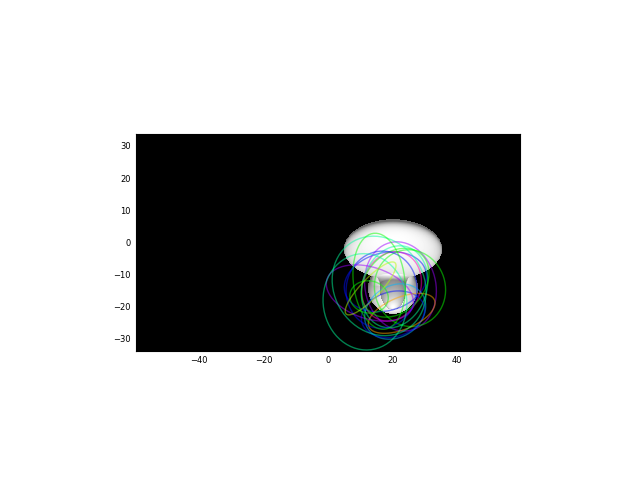

16.0507159925
32


In [1069]:
fig = pl.figure()

# Screen visualization ----------------------------------------------------
ax = pl.subplot2grid((5, 3), (1, 0), colspan=5, rowspan=3)
ax.set_facecolor('k')
ax.set_xlim([stiminfo['screen_bounds'][1], stiminfo['screen_bounds'][3]])
ax.set_ylim([stiminfo['screen_bounds'][0], stiminfo['screen_bounds'][2]])
ax.set_aspect(stiminfo['screen_aspect'])
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

curr_sz=30

xpos = stiminfo['stimulus_xpos']
ypos = stiminfo['stimulus_ypos']

# Draw stimulus diff image:
imA = images['M%i' % objectA] #
imr = rfutils.resize_image_to_coords(imA, size_deg=curr_sz, pix_per_deg=stiminfo['pix_per_deg'])
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
im0 = ax.imshow(imA, cmap='gray', extent=extent)

## plot RFs -----------------------------------------------
print(len(matched_rois))
for rid in matched_rois[0::2]:  
    #roi_color = weight_colors[list(top_coef_cells).index(roi)]
    roi_color = ori_colors[osi_fits.loc[rid]['tested_theta']]
    
    r2, sx, sy, th, x0, y0 = rffits.loc[rid]
    if marker_style == 'weights':
        feature_weight = trained_svc.coef_.ravel()[train.columns.tolist().index(roi)]
        ax.plot(x0, y0, color=roi_color, marker='o', markersize=np.abs(feature_weight)*100., \
                markerfacecolor='none', markeredgecolor=roi_color, alpha=1)

    elif marker_style == 'centroids':
        ax.plot(x0, y0, color=roi_color, marker='+', markersize=5, \
                markerfacecolor=roi_color, markeredgecolor=roi_color, alpha=1)
        
    elif marker_style == 'rfs':
        s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.), np.rad2deg(th))
        v_ell = np.array(s_ell.exterior.coords.xy)
        p_ell = Polygon(v_ell.T, edgecolor=roi_color, alpha=0.5, facecolor='none', lw=1)
        ax.add_patch(p_ell)


<IPython.core.display.Javascript object>


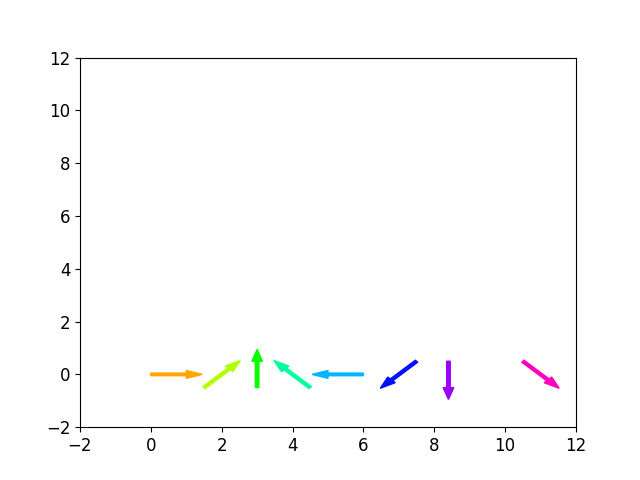

0
1
2
3
4
5
6
7


In [1177]:

def plot_point(point, angle, length):
    '''
    point - Tuple (x, y)
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.
    Will plot the line on a 10 x 10 plot.
    '''

    # unpack the first point
    x, y = point

    # find the end point
    endy = length * math.sin(math.radians(angle))
    endx = length * math.cos(math.radians(angle))
    
    return endx, endy


def draw_line(x, y, angle, c='k'):
    r = 1  # or whatever fits you
    pl.arrow(x, y, r*np.cos(np.deg2rad(angle)), r*np.sin(np.deg2rad(angle)), color=c)
    
    
length=1

fig = pl.figure()
ax = pl.subplot(111)


for x in np.arange(0, len(oris)):
    print x
    angle = oris[x]
    
    if 0 < angle < 180:
        point = (x*1.5, -0.5)
    elif angle==0 or angle==180:
        point = (x*1.5, 0)
    elif angle == 270:
        point = (x*1.4, 0.5)
    else:
        point = (x*1.5, 0.5)
    x, y = point
    #endx, endy = plot_point(point, angle, length)
    #print(endx, endy)

    # plot the points
    ax.set_ylim([-2, 12])   # set the bounds to be 10, 10
    ax.set_xlim([-2, 12])
    #ax.plot([x, endx], [y, endy], color=ori_colors[angle], label=angle)
    
    r=1
    pl.arrow(x, y, r*np.cos(np.deg2rad(angle)), r*np.sin(np.deg2rad(angle)),
             color=ori_colors[angle],
             width=.1)
    
ax.legend()


In [1024]:
rffits.head()

r2    sigma_x    sigma_y     theta         x0         y0
5   0.552829   8.063515  11.491237 -1.426131  17.836423 -12.234272
9   0.852096  10.161037   8.325968 -0.027895  24.116823 -11.728018
14  0.492286   7.913539   9.891567  0.377481  19.766983 -13.688597
17  0.855683  13.000644   9.677829 -0.194002  24.359459 -15.700910
21  0.664964  12.121455   9.926422 -0.165733  22.522499 -13.689643

In [983]:
images.keys()

['M92', 'M106', 'M53', 'M66', 'M40', 'M27', 'M0', 'M79', 'M14']

In [984]:
pix_per_deg

NameError: name 'pix_per_deg' is not defined

In [397]:
sdf =  DATA[datakey]['sdf'].copy()
object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
sizes = sorted(stimdf['size'].unique())

# Select subset of data
sample_labels = DATA[datakey]['data']['config'].copy()
included_trial_nums = np.array(sample_labels[sample_labels.isin(object_configs)].index.tolist())
sample_data = DATA[datakey]['data'].loc[included_trial_nums].copy()

# Get labels
targets = pd.DataFrame(sample_labels.loc[included_trial_nums], columns=['config'])
targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]


pass_rois = lumdf[lumdf['datakey']==datakey]['rid'].unique()

curr_rois = [r for r in pass_rois if r in sample_data.columns]
print(len(curr_rois))
dd=[]

for C_value in [0.001, 0.1, 1, 10, 100]:
    for rid in curr_rois:

        results = []
        chance_results=[]
        for n_iter in np.arange(0, 50):

            # Equalize df/f across neurons:  Normalize each neuron to have 
            # the same (zero) mean and (unit) SD across the Ms stimuli
            zdata = (sample_data[rid] - sample_data[rid].mean()) / sample_data[rid].std() # zscore each neuron

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            chance_train_data=[]; chance_test_data=[];
            chance_train_labels=[]; chance_test_labels=[];
            for sz in sizes:
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials].values
                yi = targets.loc[curr_trials]['label'].values

                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)

            #print('---')
            train_data = np.hstack(train_data).reshape(-1, 1)
            train_labels = np.hstack(train_labels)
            #print("Train:", train_data.shape, train_labels.shape)
            test_data = np.hstack(test_data).reshape(-1, 1)
            test_labels = np.hstack(test_labels)
            #print("Test:", test_data.shape, test_labels.shape)

            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=3,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())
            results.append(pd.DataFrame(iterdict, index=[n_iter]))

        ddf = pd.concat(results, axis=0)

        results_across_iters = dict(ddf.mean())
        results_across_iters.update({'datakey': datakey, 'rid': rid, 'visual_area': visual_area, 'C': C_value})
    
        dd.append(results_across_iters)
        
        

83


In [403]:
dd = pd.concat([pd.DataFrame(d, index=[i]) for i, d in enumerate(dd)], axis=0)


<IPython.core.display.Javascript object>


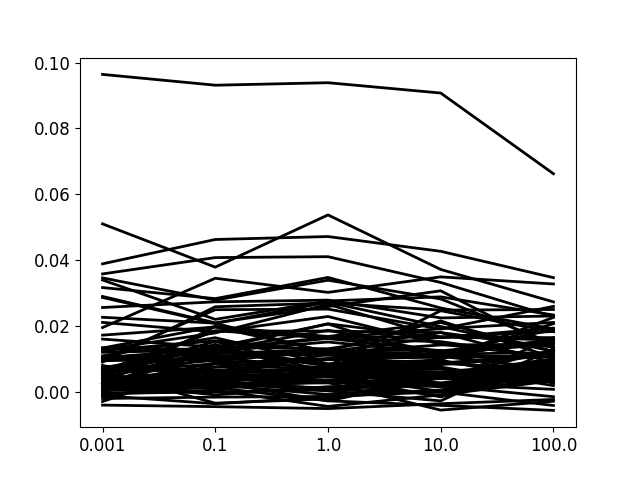

In [428]:
fig, ax = pl.subplots() #.figure()

for rid, g in dd.groupby(['rid']):
    vals = [gg['train_accuracy'].mean()-gg['test_accuracy'].mean() for c, gg in g.groupby(['C'])]
    cs = [c for c, gg in g.groupby(['C'])]
    
    ax.plot(np.arange(0, len(cs)), vals, 'k', lw=2)
    ax.set_xticks(np.arange(0, len(cs)))
    ax.set_xticklabels(cs)

In [412]:
c

100.0

In [223]:
# THIS DOESNT WORK. ALL 0s or SAME VALUE, depending on bins

    # Calculate MI(L; O) for this object pair
    #tmprf = rflums[(rflums['rid']==rid) & (rflums['morphlevel'].isin(object_pair))].copy()
    #tmprf = rflums[(rflums['rid']==rid) ].copy()
#     tmprf = populate_bins(tmprf, rkey='RF_luminance', n_bins=3)
#     state_counts = tmprf.groupby(['bin', 'morphlevel']).size().reset_index(name='count')
#     ntrials_curr = state_counts['count'].sum()
#     I_lo_curr = get_mi(state_counts, ntrials_curr, a='morphlevel', b='bin')



TypeError: float argument required, not Series

In [241]:
tmprf = rflums[(rflums['rid']==rid) & (rflums['object'].isin(mp))]
tmprf = populate_bins(tmprf, rkey='RF_luminance', n_bins=5)
state_counts = tmprf.groupby(['bin', 'object']).size().reset_index(name='count')
ntrials_curr = state_counts['count'].sum()
I_lo_curr = get_mi(state_counts, ntrials_curr, a='object', b='bin')


ValueError: Bin edges must be unique: array([ nan,  nan,  nan,  nan,  nan,  nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

<IPython.core.display.Javascript object>


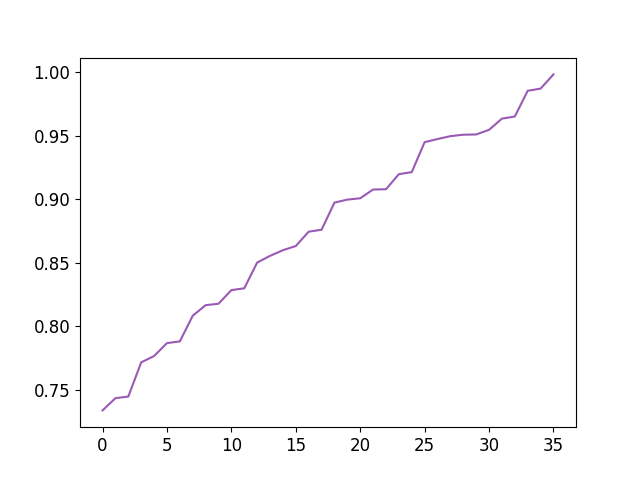

In [261]:
pl.figure()
pl.plot(sorted(lumratios[lumratios['rid']==17]['lumratio']))

# I(R; S) = I(R; T|O) + I(R; O)



I(R; O)  The information that R conveys about object identity 
         when responses across all views of the object across 
         all presentations considered together.
         
I(R; T|O)  The information R carries about the specific transformation
           of a given object.


In [ ]:
rid = 17
roilums = rflums[rflms['rid']==rid]

In [ ]:
mp = mpairs[0]
print(mp)
roilums['object'].isin(mp)


# Test N bins

In [55]:
DATA.keys()[0:5]

['20190512_JC083_fov1',
 '20190420_JC076_fov1',
 '20190603_JC080_fov1',
 '20190506_JC080_fov1',
 '20190510_JC083_fov1']

In [56]:
session, animalid, fovn = datakey.split('_')
dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fovnum']==int(fovn[3:]))]


animalid experiment            fov   session visual_area  fovnum
0    JC084        rfs  FOV1_zoom2p0x  20190522          V1       1
1    JC084   gratings  FOV1_zoom2p0x  20190522          V1       1
2    JC084      blobs  FOV1_zoom2p0x  20190522          V1       1
3    JC084     retino  FOV1_zoom2p0x  20190522          V1       1

In [57]:
aggr_data_id = data_id.split('|')[-1]
print(aggr_data_id)
print(outdir)

traces001-dff_ROC-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis


# Calculate MI as function of n_bins

In [150]:
mi_dfs = []

for dii, datakey in enumerate(DATA.keys()):

    session, animalid, fovn = datakey.split('_')
    visual_area = dsets[(dsets['animalid']==animalid) \
                        & (dsets['session']==session) \
                        & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

    # Blob trial metrics
    neuraldata = DATA[datakey]['data'].copy()
    trial_key = DATA[datakey]['trial_key'].copy()
    blobstats = pd.concat([neuraldata, trial_key], axis=1)
    blobstats.index = blobstats['trial']
    blobstats.drop('trial', axis=1, inplace=True)

    # ROI list for objects
    rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
    sizes = sorted(DATA[datakey]['sdf']['size'].unique())

    # RF fit data
    g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # Get ROIs for both
    print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    print("%i rois common to both." % len(roi_list))

    # Get RF/screen param info
    rfparams = get_rfparams(screen_info, rfstats)
    
    # Calculate MI as function of n_bins
    for n_bins in [2, 3, 5, 10, 20]:

        # Calculate MI for all cells
        MI = []; avg_counts=[];
        for rid in roi_list:
            tmpd = pd.DataFrame(blobstats[[rid, 'config']].values, columns=['dff', 'config'], index=blobstats[rid].index)
            mi, state_counts = calculate_mutual_information(tmpd, n_bins=n_bins)
            MI.append(mi)
            avg_counts.append((state_counts['count'].mean(), state_counts['count'].std()))

        nsamples = len(MI)
        currdf = pd.DataFrame({'MI': MI,
                               'mean_counts': [val[0] for val in avg_counts],
                               'std_counts': [val[1] for val in avg_counts],
                            'visual_area': [visual_area for _ in np.arange(0, nsamples)],
                            'datakey': [datakey for _ in np.arange(0, nsamples)],
                            'rid': roi_list,
                               'n_bins': [n_bins for _ in np.arange(0, nsamples)]})

        mi_dfs.append(currdf)

mi_dfs = pd.concat(mi_dfs, axis=0)


... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 145
82 rois common to both.
... [JC080|20190506|FOV

... [JC078|20190430|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 101, RFs: 152
70 rois common to both.
... [JC110|20191006|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 104, RFs: 150
65 rois common to both.
... [JC084|20190525|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 90, RFs: 113
69 rois common to both.
... [JC091|201906

<IPython.core.display.Javascript object>


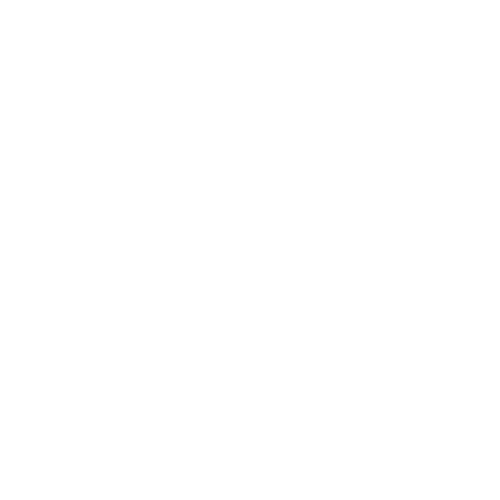

<IPython.core.display.Javascript object>


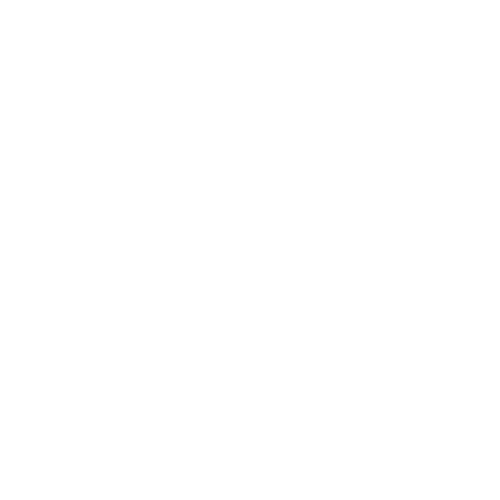

<IPython.core.display.Javascript object>


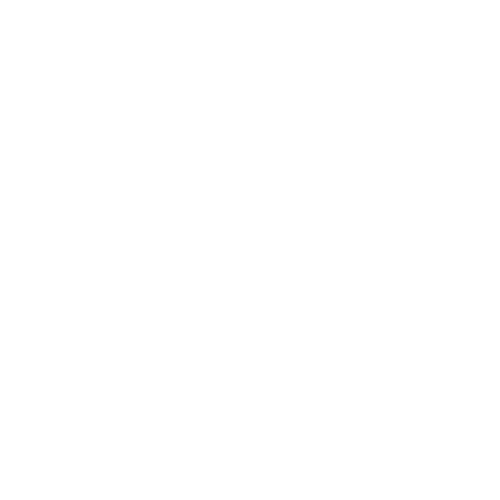

<IPython.core.display.Javascript object>


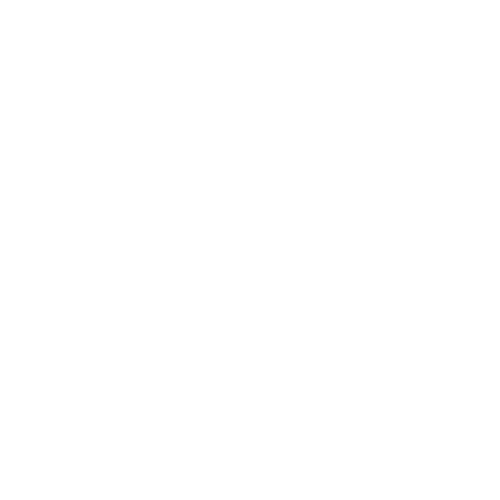

In [118]:
for n_bins, g in mi_dfs.groupby(['n_bins']):
    # Plot
    gplot = sns.catplot(x='visual_area', y='MI', kind='box', data=g, palette='colorblind',
                order=['V1', 'Lm', 'Li'] )
    pl.ylim([0, 0.8])

    label_figure(gplot.fig, aggr_data_id)
    pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells.svg' % n_bins))
    
    pl.close()

MI  n_bins     rid
visual_area                            
Li            44.452670    1670   60521
Lm            98.608972    3075   83082
V1           159.813503    4555  141597

<IPython.core.display.Javascript object>


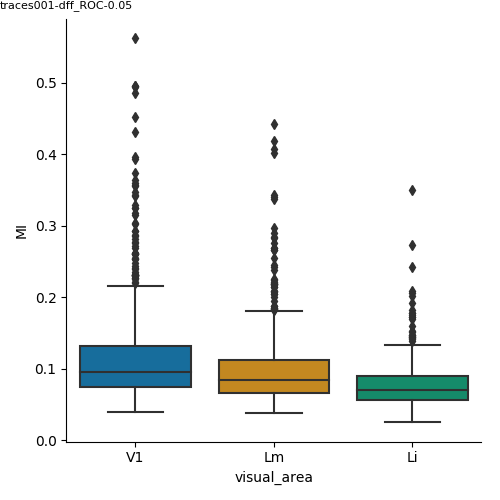

In [77]:
g = sns.catplot(x='visual_area', y='MI', kind='box', data=mi_dfs[mi_dfs['n_bins']==3], palette='colorblind',
            order=['V1', 'Lm', 'Li'] )

label_figure(g.fig, aggr_data_id)
pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells.svg' % n_bins))

In [87]:
visual_areas = ['V1', 'Lm', 'Li']
viscols = sns.color_palette('colorblind', n_colors=3)
area_colors = dict((vis, col) for vis, col in zip(visual_areas, viscols))


In [97]:

bin_clist = sns.color_palette('cubehelix', n_colors=len(mi_dfs['n_bins'].unique()))
bin_colors = dict((n_bins, bcol) for n_bins, bcol in zip(sorted(mi_dfs['n_bins'].unique()), bin_clist))



In [113]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


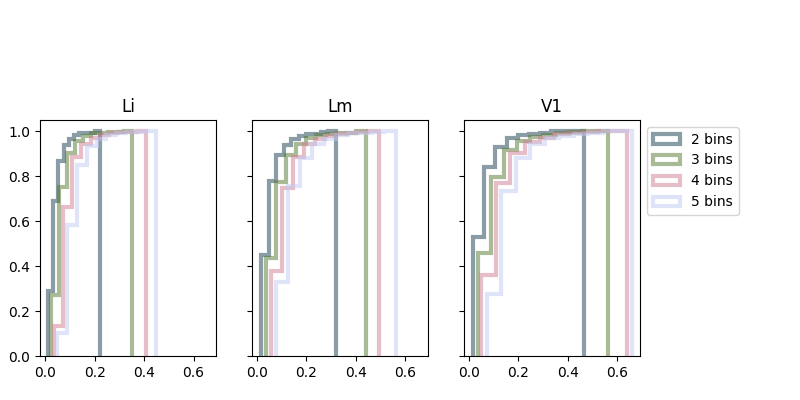

MI-by-nbins_per-area


In [114]:
cdf = True
#kwargs = {'cumulative': True}
fig, axes = pl.subplots(1, 3, sharex=True, sharey=True, figsize=(8,4))
ai = 0
for visual_area, gdf in mi_dfs.groupby(['visual_area']):
    for n_bins, ndf in gdf.groupby(['n_bins']):
        ax = axes[ai]
        values = ndf['MI'].values
        weights = np.ones_like(values)/float(len(values))

        ax.hist(values, 
                cumulative=cdf,
                label='%i bins' % n_bins,
                color=bin_colors[n_bins], #area_colors[visual_area],
                histtype='step', alpha=0.5, lw=3,
                normed=0, weights=weights)
    ax.set_title(visual_area)
    ai += 1
pl.subplots_adjust(left=0.05, right=0.8, top=0.7)
ax.legend(bbox_to_anchor=(1.0, 1))

figname = 'MI-by-nbins_per-area'
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print figname

# Plot average MI and n trials per bin as a function of N_BINS

In [152]:
ndf

MI              datakey  mean_counts  n_bins  rid  std_counts  \
0   0.076271  20190512_JC083_fov1    15.500000       2    4    4.900010   
1   0.027922  20190512_JC083_fov1    15.500000       2    6    3.036811   
2   0.024925  20190512_JC083_fov1    15.500000       2    9    2.872721   
3   0.104948  20190512_JC083_fov1    15.500000       2   11    5.791844   
4   0.054505  20190512_JC083_fov1    15.500000       2   13    4.198364   
5   0.039264  20190512_JC083_fov1    15.500000       2   20    3.574602   
6   0.040806  20190512_JC083_fov1    15.500000       2   25    3.652867   
7   0.095834  20190512_JC083_fov1    15.656566       2   28    5.157047   
8   0.044543  20190512_JC083_fov1    15.500000       2   29    3.820466   
9   0.038400  20190512_JC083_fov1    15.500000       2   35    3.551924   
10  0.023584  20190512_JC083_fov1    15.500000       2   36    2.794294   
11  0.094598  20190512_JC083_fov1    15.500000       2   42    5.428135   
12  0.028869  20190512_JC083_fov1    15.500000       2   48    3.083026   
13  0.055590  20190512_JC083_fov1    15.500000       2   52    4.250965   
14  0.022698  20190512_JC083_fov1    15.500000       2   59    2.743219   
15  0.028158  20190512_JC083_fov1    15.500000       2   65    3.056703   
16  0.032151  20190512_JC083_fov1    15.500000       2   66    3.242707   
17  0.036537  20190512_JC083_fov1    15.500000       2   72    3.471384   
18  0.021402  20190512_JC083_fov1    15.500000       2   73    2.668560   
19  0.034586  20190512_JC083_fov1    15.500000       2   77    3.376987   
20  0.036835  20190512_JC083_fov1    15.500000       2   79    3.465559   
21  0.045966  20190512_JC083_fov1    15.500000       2   87    3.878196   
22  0.053683  20190512_JC083_fov1    15.500000       2   89    4.169393   
23  0.035636  20190512_JC083_fov1    15.500000       2   93    3.424511   
24  0.041011  20190512_JC083_fov1    15.500000       2  101    3.663911   
25  0.057798  20190512_JC083_fov1    15.500000       2  107    4.321663   
26  0.047580  20190512_JC083_fov1    15.500000       2  109    3.945334   
27  0.086260  20190512_JC083_fov1    15.500000       2  141    5.246451   
28  0.031524  20190512_JC083_fov1    15.500000       2  143    3.192479   
29  0.119895  20190512_JC083_fov1    15.500000       2  144    6.127435   
..       ...                  ...          ...     ...  ...         ...   
28  0.038253  20190513_JC078_fov1    14.500000       2  237    3.292170   
29  0.055980  20190513_JC078_fov1    14.500000       2  259    3.950451   
30  0.075362  20190513_JC078_fov1    14.500000       2  260    4.619895   
31  0.043688  20190513_JC078_fov1    14.500000       2  262    3.529100   
32  0.041698  20190513_JC078_fov1    14.500000       2  263    3.424511   
33  0.028940  20190513_JC078_fov1    14.500000       2  268    2.893741   
34  0.035144  20190513_JC078_fov1    14.500000       2  273    3.160680   
35  0.055747  20190513_JC078_fov1    14.500000       2  275    3.960665   
0   0.112938  20190502_JC076_fov1    13.000000       2    0    5.021167   
1   0.061866  20190502_JC076_fov1    13.000000       2    4    3.744356   
2   0.029019  20190502_JC076_fov1    13.000000       2    6    2.597590   
3   0.021112  20190502_JC076_fov1    13.000000       2   11    2.220201   
4   0.044832  20190502_JC076_fov1    13.000000       2   24    3.209833   
5   0.031008  20190502_JC076_fov1    13.000000       2   82    2.681775   
6   0.049056  20190502_JC076_fov1    13.000000       2   84    3.357488   
7   0.038659  20190502_JC076_fov1    13.000000       2   99    2.981424   
8   0.052482  20190502_JC076_fov1    13.000000       2  107    3.446562   
9   0.035511  20190502_JC076_fov1    13.000000       2  117    2.863917   
10  0.028679  20190502_JC076_fov1    13.000000       2  120    2.581989   
11  0.033664  20190502_JC076_fov1    13.000000       2  125    2.792486   
12  0.048113  20190502_JC076_fov1    13.000000       2  130    3.327267   
13  0.096444  20190502_JC076_fov1  

<IPython.core.display.Javascript object>


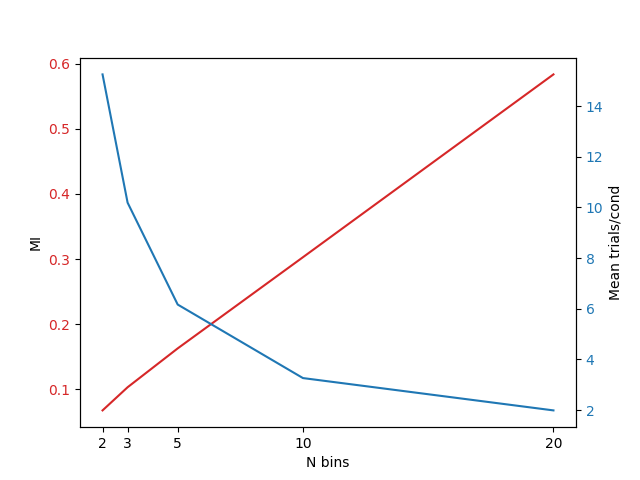

In [434]:
col1 = 'tab:red'
col2 = 'tab:blue'

fig, ax = pl.subplots() #pl.figure()
xv = [n_bins for n_bins, ndf in mi_dfs.groupby(['n_bins'])]
yv = [ndf['MI'].mean() for n_bins, ndf in mi_dfs.groupby(['n_bins'])]
ax.plot(xv, yv, color=col1)
ax.tick_params(axis='y', labelcolor=col1)
ax.set_ylabel('MI')

ax2 = ax.twinx()
yv2 = [ndf['mean_counts'].mean() for n_bins, ndf in mi_dfs.groupby(['n_bins'])]
ax2.plot(xv, yv2, color=col2)
ax2.tick_params(axis='y', labelcolor=col2)
ax2.set_ylabel("Mean trials/cond")

ax.set_xlabel('N bins')
ax.set_xticks(xv)
ax.set_xticklabels(xv)

pl.savefig(os.path.join(outdir, 'MI-vs-nreps_by-nbins.svg'))

# Choose N bins

In [441]:
import scikit_posthocs as sp


In [ ]:
n_bins = 3
mdf = []
for dii, datakey in enumerate(DATA.keys()):

    session, animalid, fovn = datakey.split('_')
    visual_area = dsets[(dsets['animalid']==animalid) \
                        & (dsets['session']==session) \
                        & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

    # Blob trial metrics
    neuraldata = DATA[datakey]['data'].copy()
    trial_key = DATA[datakey]['trial_key'].copy()
    blobstats = pd.concat([neuraldata, trial_key], axis=1)
    blobstats.index = blobstats['trial']
    blobstats.drop('trial', axis=1, inplace=True)

    # ROI list for objects
    rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
    sizes = sorted(DATA[datakey]['sdf']['size'].unique())

    # RF fit data
    g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # Get ROIs for both
    print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    print("%i rois common to both." % len(roi_list))

    # Get RF/screen param info
    rfparams = get_rfparams(screen_info, rfstats)

    print("--- calculating RF luminance for each cell's RF ---")
    rf_luminances = get_rf_luminances(images, rfstats, rfparams, roi_list=roi_list, 
                                      pix_per_deg=pix_per_deg, sizes=sizes)
    

In [497]:
rf_luminances.groupby(['rid']).count()

RF_luminance  object  size
rid                            
0              45      45    45
4              45      45    45
6              45      45    45
11             45      45    45
24             45      45    45
82             45      45    45
84             45      45    45
99             45      45    45
107            45      45    45
117            45      45    45
120            45      45    45
125            45      45    45
130            45      45    45
135            45      45    45
169            45      45    45
181            45      45    45
187            45      45    45
190            45      45    45
192            45      45    45
196            45      45    45
213            45      45    45
219            45      45    45

In [382]:
n_bins = 3
mdf = []
for dii, datakey in enumerate(DATA.keys()):

    session, animalid, fovn = datakey.split('_')
    visual_area = dsets[(dsets['animalid']==animalid) \
                        & (dsets['session']==session) \
                        & (dsets['fovnum']==int(fovn[3:]))]['visual_area'].iloc[0]

    # Blob trial metrics
    neuraldata = DATA[datakey]['data'].copy()
    trial_key = DATA[datakey]['trial_key'].copy()
    blobstats = pd.concat([neuraldata, trial_key], axis=1)
    blobstats.index = blobstats['trial']
    blobstats.drop('trial', axis=1, inplace=True)

    # ROI list for objects
    rois_objects = np.array(DATA[datakey]['data'].columns.tolist())
    sizes = sorted(DATA[datakey]['sdf']['size'].unique())

    # RF fit data
    g = dsets[(dsets['animalid']==animalid) & (dsets['session']==session) & (dsets['fov']==fov)]
    curr_exp = 'rfs10' if 'rfs10' in g['experiment'].values else 'rfs'
    exp = util.ReceptiveFields(curr_exp, animalid, session, fov, traceid=traceid)
    rfstats, rois_rfs, nrois_total = exp.get_rf_fits(response_type=response_type, fit_thr=0.05)

    # Get ROIs for both
    print("Blobs: %i, RFs: %i" % (len(rois_objects), len(rois_rfs)))
    roi_list = np.intersect1d(rois_objects, rois_rfs)
    print("%i rois common to both." % len(roi_list))

    # Get RF/screen param info
    rfparams = get_rfparams(screen_info, rfstats)

    print("--- calculating RF luminance for each cell's RF ---")
    rf_luminances = get_rf_luminances(images, rfstats, rfparams, roi_list=roi_list, 
                                      pix_per_deg=pix_per_deg, sizes=sizes)

    # Calculate MI for all cells
    print("--- calculating MI for each cell ---")
    MI = []; avg_counts=[];
    MI_lum = [];
    for rid in roi_list:
        tmpd = pd.DataFrame(blobstats[[rid, 'config']].values, columns=['dff', 'config'], index=blobstats[rid].index)
    
        # Only get image-trials
        image_configs = [c for c in sdf.index.tolist() if sdf['morphlevel'][c]!=-1]
        tmpd = tmpd[tmpd['config'].isin(image_configs)]
        
        # Get RF info
        tmprf = rf_luminances[rf_luminances['rid']==rid].copy()

        mi, state_counts, mi_lum = calculate_mutual_information_split(tmpd, tmprf, n_bins=n_bins)
        MI.append(mi)
        MI_lum.append(mi_lum)
        avg_counts.append( (state_counts['count'].mean(), state_counts['count'].std()) )


    nsamples = len(MI)
    currdf = pd.DataFrame({'MI': MI,
                           'MI_lum': MI_lum,
                           'mean_counts': [val[0] for val in avg_counts],
                           'std_counts': [val[1] for val in avg_counts],
                        'visual_area': [visual_area for _ in np.arange(0, nsamples)],
                        'datakey': [datakey for _ in np.arange(0, nsamples)],
                        'rid': roi_list})

    mdf.append(currdf)

mdf = pd.concat(mdf, axis=0)


... [JC083|20190512|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 114, RFs: 146
67 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC076|20190420|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 45, RFs: 160
34 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC080|20190603|FOV1_zoom2p0x] creating rfs object
GET ROI SET: rois001
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_stati

--- calculating MI for each cell ---
... [JC097|20190616|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... renaming experiment to run name: combined_rfs10_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 188, RFs: 181
126 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC083|20190508|FOV1_zoom2p0x] creating gratings object
GET ROI SET: rois001
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
Blobs: 122, RFs: 131
86 rois common to both.
--- calculating RF luminance for each cell's RF ---
--- calculating MI for each cell ---
... [JC099|20190612|FOV1_zoom2p0x] creating rfs10 object
GET ROI SET: rois001
... getting data paths - name: rfs10
... re

In [384]:
with open(os.path.join(outdir, 'mutual-information.pkl'), 'wb') as f:
    pkl.dump(mdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [477]:
mdf['MI_nonlum'] = mdf['MI'] - mdf['MI_lum']
mdf['f_high'] = mdf['MI_nonlum'] / mdf['MI']
mdf['f_low'] = mdf['MI_lum'] / mdf['MI']


In [397]:
std

[0.037723403581616542, 0.052870329396294644, 0.06281848890762104]

<IPython.core.display.Javascript object>


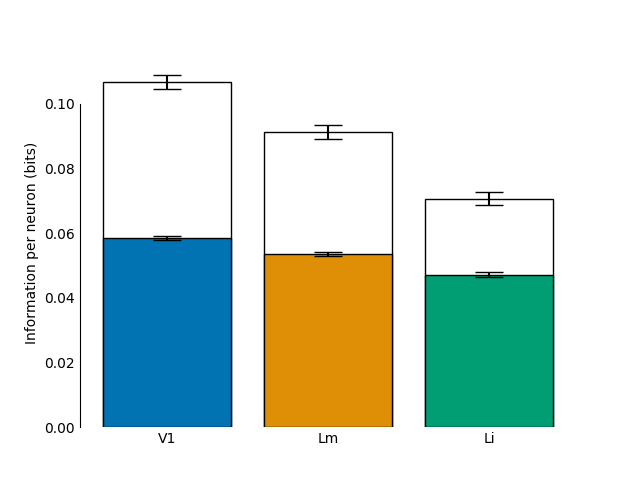

In [490]:
fig, ax = pl.subplots()

# Plot mutual info
means = [mdf[mdf['visual_area']==vis]['MI'].mean() for vis in visual_areas]
std = [spstats.sem(mdf[mdf['visual_area']==vis]['MI']) for vis in visual_areas]
#std = [mdf[mdf['visual_area']==vis]['MI'].std() for vis in visual_areas]
positions=[0, 1, 2]
bars = ax.bar(positions, means, yerr=std, align='center', alpha=1.0, ecolor='black', capsize=10, 
             color='w', linewidth=1, edgecolor='k')
# for bar, visual_area in zip(bars, visual_areas):
#     bar.set_color('w')
#     bar.set_alpha(1)

means_non = [mdf[mdf['visual_area']==vis]['MI_nonlum'].mean() for vis in visual_areas]
std_non = [spstats.sem(mdf[mdf['visual_area']==vis]['MI_nonlum']) for vis in visual_areas]
#std_non = [mdf[mdf['visual_area']==vis]['MI_nonlum'].std() for vis in visual_areas]
positions=[0, 1, 2]
bars = ax.bar(positions, means_non, yerr=std_non, align='center', alpha=0.5, 
              ecolor='k', capsize=10,
             linewidth=1, edgecolor='k')
for bar, visual_area in zip(bars, visual_areas):
    bar.set_color(area_colors[visual_area])
    bar.set_alpha(1)
    bar.set_linewidth(1)
    bar.set_edgecolor('k')
    
ax.set_xticks(positions) #(visual_areas)
ax.set_xticklabels(visual_areas)
ax.tick_params(axis='both', length=0)
ax.set_ylabel('Information per neuron (bits)')
label_figure(g.fig, aggr_data_id)

sns.despine(trim=True, bottom=True)

pl.savefig(os.path.join(outdir, 'MI_split.svg'))
pl.savefig(os.path.join(outdir, 'MI_split.png'))


# F_high

In [487]:
def calculate_stats_by_area(mdf, metric='MI'):

    g= sns.catplot(x='visual_area', y=metric, kind='bar', data=mdf, palette='colorblind',
               order=['V1', 'Lm', 'Li'] )

    
    c1 = mdf[mdf['visual_area']=='V1'][metric]
    c2 = mdf[mdf['visual_area']=='Lm'][metric]
    c3 = mdf[mdf['visual_area']=='Li'][metric]
    print(c1.shape, c2.shape, c3.shape)

    # Shapiro-Wilk normality test 
    print("Shapiro-Wilk normality:", spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

    F, p = spstats.f_oneway(c1, c2, c3)
    print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

    scores = np.hstack([c1, c2, c3])
    groups = np.hstack([['V1' for _ in range(len(c1))], 
                       ['Lm' for _ in range(len(c2))],
                       ['Li' for _ in range(len(c3))]])
    # Note that data in sheet have been preformatted in Group and Score columns 
    # Boolean values refer to whether we should reject the null hypothesis (H0) that
    # the means of the tested pair are statistically similar (non-significant differences)
    mcobj = ml.MultiComparison(scores, groups)
    out = mcobj.tukeyhsd(0.05) 
    print(out)

    print(spstats.kruskal(c1, c2, c3))
    statsdf = mdf[['visual_area', metric]].copy()
    print(sp.posthoc_dunn(statsdf, val_col=metric, group_col='visual_area', p_adjust='bonferroni')) #'fdr_by')
    
    return g

In [484]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


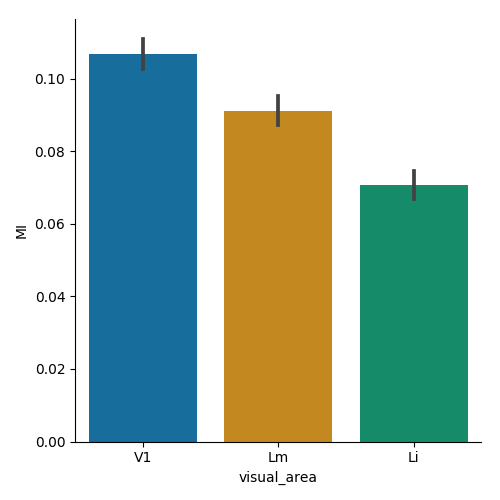

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7505552172660828, 6.627801622061434e-35), (0.7290875911712646, 2.077272679146e-30), (0.7476382255554199, 3.093683511287677e-22))
F statistic = 53.345 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0205  0.0116 0.0294  True 
  Li     V1    0.0361  0.0277 0.0444  True 
  Lm     V1    0.0156  0.0087 0.0224  True 
-------------------------------------------
KruskalResult(statistic=183.61651431948667, pvalue=1.343323221736018e-40)
              Li            Lm            V1
Li -1.000000e+00  4.006227e-13  4.800194e-40
Lm  4.006227e-13 -1.000000e+00  6.512182e-11
V1  4.800194e-40  6.512182e-11 -1.000000e+00


In [493]:
metric='MI'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))


<IPython.core.display.Javascript object>


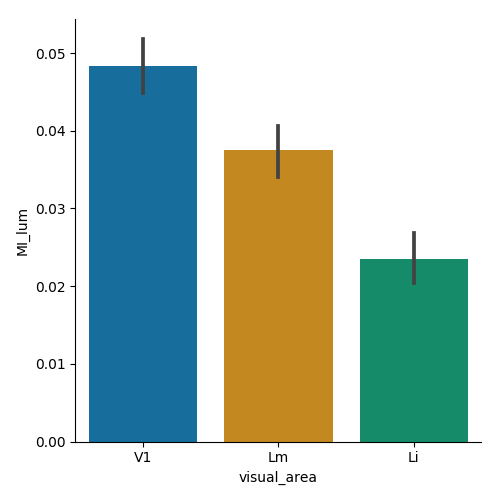

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7094955444335938, 5.9523746322497905e-37), (0.6896823644638062, 4.472202053165979e-32), (0.6138126254081726, 1.0781328865660525e-26))
F statistic = 34.365 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0141  0.0065 0.0217  True 
  Li     V1    0.0248  0.0176 0.032   True 
  Lm     V1    0.0107  0.0049 0.0166  True 
-------------------------------------------
KruskalResult(statistic=129.33353598052236, pvalue=8.2334053884913261e-29)
              Li            Lm            V1
Li -1.000000e+00  5.372132e-09  2.381671e-28
Lm  5.372132e-09 -1.000000e+00  1.764815e-08
V1  2.381671e-28  1.764815e-08 -1.000000e+00


In [494]:
metric='MI_lum'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))


<IPython.core.display.Javascript object>


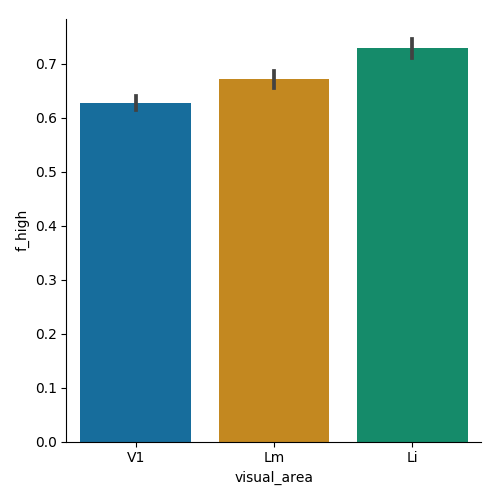

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.9692666530609131, 6.074017699399248e-13), (0.9419101476669312, 8.945549684303503e-15), (0.9164955615997314, 1.1338407426494945e-12))
F statistic = 35.856 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Li     Lm   -0.0575  -0.0877 -0.0272  True 
  Li     V1   -0.1006  -0.1291 -0.0722  True 
  Lm     V1   -0.0432  -0.0664 -0.0199  True 
---------------------------------------------
KruskalResult(statistic=75.377356179395974, pvalue=4.2856339661552985e-17)
              Li        Lm            V1
Li -1.000000e+00  0.000035  8.576046e-17
Lm  3.536996e-05 -1.000000  9.803982e-06
V1  8.576046e-17  0.000010 -1.000000e+00


In [491]:
metric='f_high'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))

## Stats, f_low

<IPython.core.display.Javascript object>


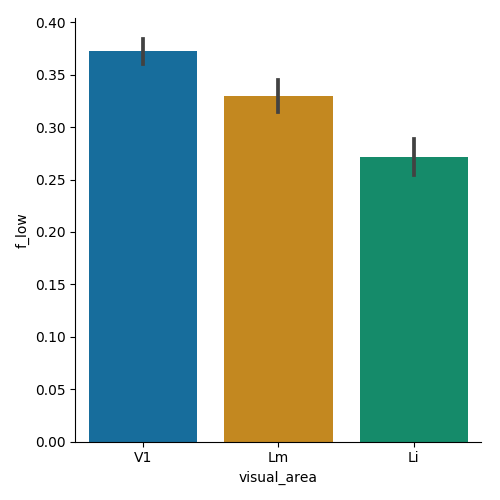

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.9692655801773071, 6.070160650170631e-13), (0.9419098496437073, 8.944685710697304e-15), (0.9164948463439941, 1.1336860269994808e-12))
F statistic = 35.856 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0575  0.0272 0.0877  True 
  Li     V1    0.1006  0.0722 0.1291  True 
  Lm     V1    0.0432  0.0199 0.0664  True 
-------------------------------------------
KruskalResult(statistic=75.377356179395974, pvalue=4.2856339661552985e-17)
              Li        Lm            V1
Li -1.000000e+00  0.000035  8.576046e-17
Lm  3.536996e-05 -1.000000  9.803982e-06
V1  8.576046e-17  0.000010 -1.000000e+00


In [488]:
metric='f_low'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))

#### Stats, I(R; S'|L)

<IPython.core.display.Javascript object>


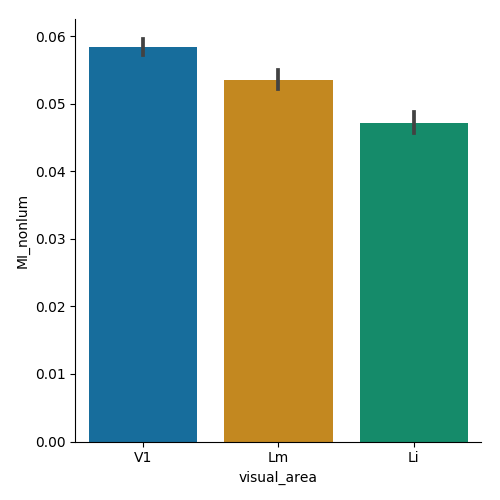

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7615834474563599, 2.6120568134125893e-34), (0.6906959414482117, 4.911658852979365e-32), (0.908942461013794, 2.5755463842376536e-13))
F statistic = 48.456 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0064  0.0035 0.0093  True 
  Li     V1    0.0112  0.0085 0.014   True 
  Lm     V1    0.0048  0.0026 0.0071  True 
-------------------------------------------
KruskalResult(statistic=122.5305421858402, pvalue=2.4707615375522554e-27)
              Li            Lm            V1
Li -1.000000e+00  1.827142e-07  2.211404e-26
Lm  1.827142e-07 -1.000000e+00  3.236547e-09
V1  2.211404e-26  3.236547e-09 -1.000000e+00


In [492]:
metric='MI_nonlum'
g = calculate_stats_by_area(mdf, metric=metric)

pl.savefig(os.path.join(outdir, '%s.svg' % metric))
pl.savefig(os.path.join(outdir, '%s.png' % metric))

## Stats - I(R; L)

<IPython.core.display.Javascript object>


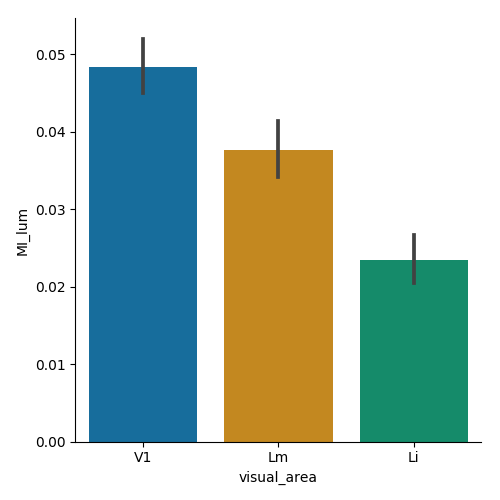

((911,), (615,), (334,))
('Shapiro-Wilk normality:', (0.7094955444335938, 5.9523746322497905e-37), (0.6896823644638062, 4.472202053165979e-32), (0.6138126254081726, 1.0781328865660525e-26))
F statistic = 34.365 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0141  0.0065 0.0217  True 
  Li     V1    0.0248  0.0176 0.032   True 
  Lm     V1    0.0107  0.0049 0.0166  True 
-------------------------------------------
KruskalResult(statistic=129.33353598052236, pvalue=8.2334053884913261e-29)
              Li        Lm            V1
Li -1.000000e+00  0.000035  8.576046e-17
Lm  3.536996e-05 -1.000000  9.803982e-06
V1  8.576046e-17  0.000010 -1.000000e+00


In [476]:
metric='MI_lum'
g = calculate_stats_by_area(mdf, metric=metric)
pl.savefig(os.path.join(outdir, '%s.svg' % metric))

<IPython.core.display.Javascript object>


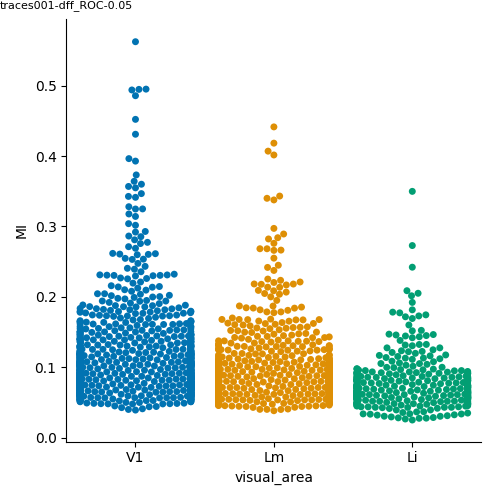

In [230]:

# Plot
g = sns.catplot(x='visual_area', y='MI', kind='swarm', data=mdf, palette='colorblind',
            order=['V1', 'Lm', 'Li'] )
#pl.ylim([0, 1.0])

label_figure(g.fig, aggr_data_id)

pl.savefig(os.path.join(outdir, 'mutual-information_equi-bins-%i_all-cells_swarm.svg' % n_bins))


#### stats

In [236]:
mdf.groupby(['visual_area']).count()

MI  datakey  mean_counts  rid  std_counts
visual_area                                            
Li           334      334          334  334         334
Lm           615      615          615  615         615
V1           911      911          911  911         911

In [245]:
min_n = 334
r1 = np.arange(0, 911)
np.random.shuffle(r1)
r2 = np.arange(0, 615)
np.random.shuffle(r2)

c1 = mdf[mdf['visual_area']=='V1']['MI'].values[r1[0:min_n]]
c2 = mdf[mdf['visual_area']=='Lm']['MI'].values[r2[0:min_n]]
c3 = mdf[mdf['visual_area']=='Li']['MI'].values
print(c1.shape, c2.shape, c3.shape)

F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
#print(scores.shape)
#print(groups.shape)


# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

((334,), (334,), (334,))
F statistic = 37.188 and probability p = 0.000
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  Li     Lm    0.0225  0.0122 0.0329  True 
  Li     V1    0.0379  0.0275 0.0483  True 
  Lm     V1    0.0153  0.005  0.0257  True 
-------------------------------------------


In [246]:
df1 = pd.DataFrame({'MI': mdf[mdf['visual_area']=='V1']['MI'].values[r1[0:min_n]],
                        'visual_area': ['V1' for _ in np.arange(0, min_n)]})
df2 = pd.DataFrame({'MI': mdf[mdf['visual_area']=='Lm']['MI'].values[r2[0:min_n]],
                        'visual_area': ['Lm' for _ in np.arange(0, min_n)]})
df3 = pd.DataFrame({'MI': mdf[mdf['visual_area']=='Li']['MI'].values,
                        'visual_area': ['Li' for _ in np.arange(0, min_n)]})
tmp_mdf = pd.concat([df1, df2, df3])

<IPython.core.display.Javascript object>


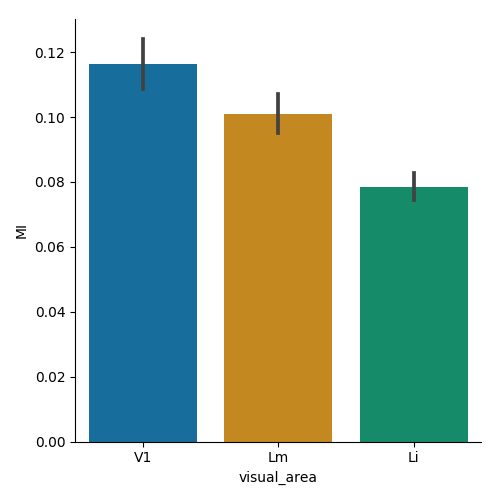

In [247]:

# Plot
g = sns.catplot(x='visual_area', y='MI', kind='bar', data=tmp_mdf, palette='colorblind',
            order=['V1', 'Lm', 'Li'] )

pl.savefig(os.path.join(outdir, 'MI-avg-by-session_random-match-nsamples.svg'))

# Average by session

In [231]:
mean_by_session = []
for vi, m in mdf.groupby(['visual_area']):
    vals = m.groupby(['datakey'])['MI'].mean()
    mean_by_session.append(pd.DataFrame({'MI': vals,
                                         'visual_area': [vi for _ in np.arange(0, len(vals))]}))
    
mean_by_session = pd.concat(mean_by_session, axis=0)

In [232]:
mean_by_session.groupby(['visual_area']).count()

MI
visual_area    
Li           13
Lm           11
V1           11

#### stats

In [233]:
import statsmodels.stats.multicomp as ml
import scipy.stats as spstats

In [234]:
c1 = mean_by_session[mean_by_session['visual_area']=='V1']['MI'].values
c2 = mean_by_session[mean_by_session['visual_area']=='Lm']['MI'].values
c3 = mean_by_session[mean_by_session['visual_area']=='Li']['MI'].values
print(c1.shape, c2.shape, c3.shape)

F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
#print(scores.shape)
#print(groups.shape)


# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

((11,), (11,), (13,))
F statistic = 8.327 and probability p = 0.001
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.0187  -0.0036 0.041  False 
  Li     V1    0.037    0.0147 0.0594  True 
  Lm     V1    0.0183  -0.0049 0.0416 False 
--------------------------------------------


In [222]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/luminance-analysis'

<IPython.core.display.Javascript object>


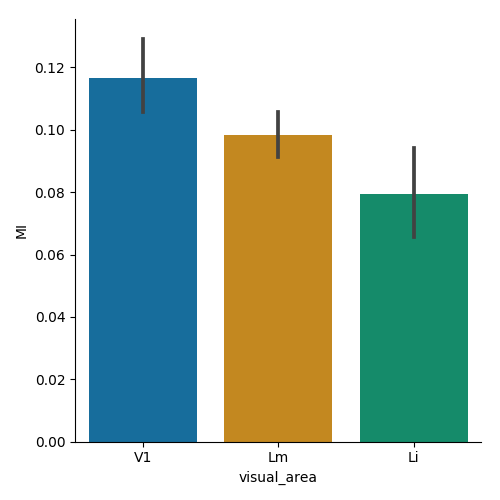

In [235]:

# Plot
g = sns.catplot(x='visual_area', y='MI', kind='bar', data=mean_by_session, palette='colorblind',
            order=['V1', 'Lm', 'Li'] )

pl.savefig(os.path.join(outdir, 'MI-avg-by-session_bar.svg'))

# MI of Luminance

In [248]:
mdf.head()

MI              datakey  mean_counts  rid  std_counts visual_area
0  0.103257  20190512_JC083_fov1    10.333333    4    3.902618          Lm
1  0.050756  20190512_JC083_fov1    10.333333    6    2.753074          Lm
2  0.039986  20190512_JC083_fov1    10.333333    9    2.448576          Lm
3  0.144819  20190512_JC083_fov1    10.333333   11    4.563742          Lm
4  0.060805  20190512_JC083_fov1    10.333333   13    2.953025          Lm